In [1]:
import pandas as pd
import numpy as np
import os

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize

In [4]:
sns.set()

In [5]:
from scipy import stats
from scipy.stats import norm, gamma, linregress
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.metrics import mean_squared_error, roc_auc_score, confusion_matrix, silhouette_score
from sklearn.ensemble import RandomForestClassifier

## Data Prep

In [6]:
s_df = pd.read_csv('nba_offense.csv')
s_df['Player'] = s_df['Player'].apply(lambda x: ' '.join(x.split(' ')[1:]))
s_df.shape

(2973, 74)

In [7]:
bbr_adv_df = pd.read_csv('bbr_nba_advanced_stats.csv')
bbr_adv_df.shape

(2986, 28)

In [8]:
bbr_ros_df = pd.read_csv('bbr_nba_roster_stats.csv')
bbr_ros_df.shape

(2988, 12)

In [9]:
bbr_df = bbr_adv_df.merge(bbr_ros_df, how='left',
                          on=['player', 'season', 'team', 'player_alt'])
bbr_df.shape

(2986, 36)

Convert Heights

In [10]:
def convert_height(height):
    feet, inches = height.split('-')
    cm = int(feet) * 12 + int(inches)
    return round(cm * 2.54, 1)

In [11]:
bbr_df['height_cm'] = bbr_df['height'].apply(convert_height)

Convert Weights

In [12]:
bbr_df['weight_kg'] = bbr_df['weight'].apply(lambda x: round(0.453592 * x, 1))

Filter in players with 200 shot possessions

In [13]:
s_df = s_df[s_df['Overall_Poss'] >= 200]
s_df.shape

(1785, 74)

Filter in players that played over 200 minutes

In [14]:
bbr_df = bbr_df[bbr_df['mp'] >= 200]
bbr_df.shape

(2268, 38)

Merge

In [15]:
s_df['Player_Alt'] = s_df['Player'].apply(lambda x: x.replace(' ', '').lower())\
                                   .apply(lambda x: x.replace("'", ''))\
                                   .apply(lambda x: x.replace('.', ''))

In [16]:
bbr_df['player_alt_alt'] = bbr_df['player_alt'].apply(lambda x: x.replace(' ', ''))\
                                               .apply(lambda x: x.replace("'", ''))\
                                               .apply(lambda x: x.replace('.', ''))\
                                               .apply(lambda x: x.lower())

In [17]:
bbr_df[bbr_df['player_alt_alt'].str.contains('lemon')]

,ranker,player,age,g,mp,per,ts_pct,fg3a_per_fga_pct,fta_per_fga_pct,orb_pct,...,pos,height,weight,birth_date,birth_country,years_experience,college,height_cm,weight_kg,player_alt_alt
1079,12,Chris Clemons,22,33,291,13.1,0.548,0.754,0.077,1.4,...,SG,5-9,180,"July 23, 1997",us,R,Campbell,175.3,81.6,chrisclemons


In [18]:
synergy_name_dict = {'kevinknoxii': 'kevinknox',
                     'danilogalinari': 'danilogallinari',
                     'louiswilliams': 'louwilliams',
                     'eneskanter': 'enesfreedom',
                     'terryrozieriii': 'terryrozier',
                     'cameronreddish': 'camreddish',
                     'jahilokafor': 'jahlilokafor',
                     'danuelhouse': 'danuelhousejr',
                     'alfarouqaminu': 'al-farouqaminu',
                     'nenehilario': 'nene',
                     'frankmason': 'frankmasoniii',
                     'larrynance': 'larrynancejr',
                     'wesleyiwundu': 'wesiwundu',
                     'robertwilliamsiii': 'robertwilliams',
                     'harrygilesiii': 'harrygiles',
                     'jamesennis': 'jamesennisiii',
                     'mohamedbamba': 'mobamba',
                     'xaviertillman': 'xaviertillmansr',
                     'patrickbeverly': 'patrickbeverley',
                     'malcomdelaney': 'malcolmdelaney',
                     'marcusmorrissr': 'marcusmorris',
                     'nicolasclaxton': 'nicclaxton',
                     'juanhernangomez': 'juanchohernangomez',
                     'guillermohernangomez': 'willyhernangomez',
                     'timothéluwawu-cabarrot': 'timotheluwawu-cabarrot'}
s_df['Player_Alt'] = s_df['Player_Alt'].apply(lambda x: synergy_name_dict[x] 
                                              if x in synergy_name_dict.keys()
                                              else x)

In [19]:
df = s_df.merge(bbr_df, how='left', 
                left_on=['Player_Alt', 'Team', 'Season'],
                right_on=['player_alt_alt', 'team', 'season'])
df = df[~df['player_alt_alt'].isna()].reset_index().drop('index', axis=1)
df.shape

(1784, 114)

In [20]:
# check 
df[['Player_Alt', 'Team', 'Season']].drop_duplicates().shape

(1784, 3)

## Playtypes

In [21]:
poss_ppp_cols = ['Spot Up_PPP', 'P&R Ball Handler_PPP', 'Transition_PPP',
                 'Cut_PPP', 'Offensive Rebounds (put backs)_PPP', 'Hand Off_PPP',
                 'P&R Roll Man_PPP', 'Isolation_PPP', 'Off Screen_PPP',
                 'Post-Up_PPP', 'Miscellaneous_PPP']

In [22]:
poss_weights_cols = ['Spot Up_Poss%', 'P&R Ball Handler_Poss%', 'Transition_Poss%',
                     'Cut_Poss%', 'Offensive Rebounds (put backs)_Poss%', 'Hand Off_Poss%',
                     'P&R Roll Man_Poss%', 'Isolation_Poss%', 'Off Screen_Poss%',
                     'Post-Up_Poss%', 'Miscellaneous_Poss%']

In [23]:
# # Check
# for weight_col in poss_weights_cols:
#     print(weight_col, df[df[weight_col].isna()].shape)

In [24]:
playtype_dfs = []
for col in poss_ppp_cols:
    playtype = col.replace('_PPP', '')
    playtype_df = pd.DataFrame()
    playtype_df['PPP'] = df[col]
    playtype_df['Poss%'] = df[f'{playtype}_Poss%'] * 100
    playtype_df['playtype'] = playtype
    playtype_dfs.append(playtype_df)

<AxesSubplot:xlabel='Poss%', ylabel='playtype'>

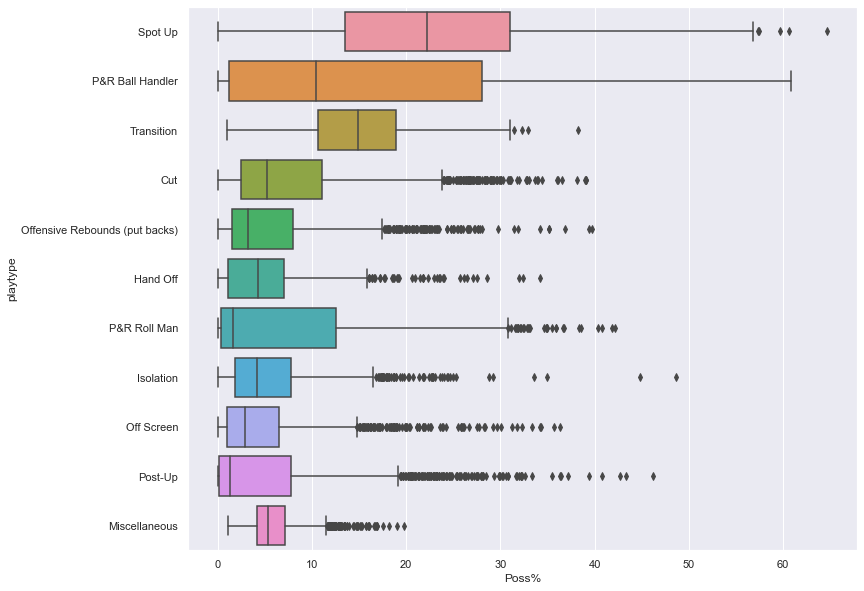

In [25]:
figsize(12, 10)
sns.boxplot(x="Poss%", y="playtype", data=pd.concat(playtype_dfs))

<AxesSubplot:xlabel='PPP', ylabel='playtype'>

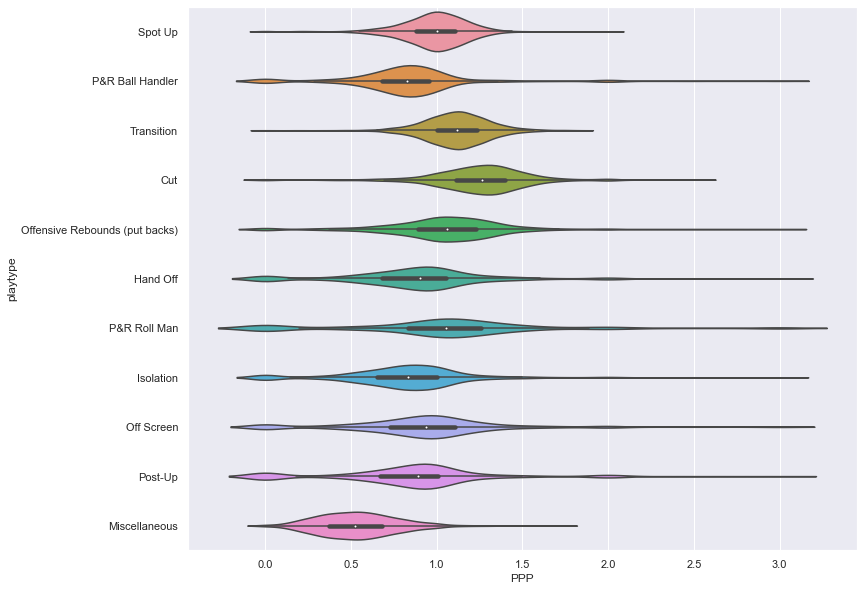

In [26]:
figsize(12, 10)
sns.violinplot(x="PPP", y="playtype", data=pd.concat(playtype_dfs))

## Clustering

In [27]:
def plot_elbow_plot(x, scaler=None, sample_weight=[]):
    if scaler:
        x = scaler.transform(x)
    
    ssdist_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        km = KMeans(n_clusters=k, init='k-means++')
        if len(sample_weight) > 0:
            km.fit(x, sample_weight=sample_weight)
        else:
            km.fit(x)
        ssdist_list.append(km.inertia_)

    # Plot
    # Plot the elbow
    plt.plot(k_list, ssdist_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_sitances')
    plt.title('The Elbow Method showing the optimal k')

In [28]:
def plot_silhouette_score(x, scaler=None, sample_weight=[]):
    if scaler:
        x = scaler.transform(x)
    
    avg_ss_list = []
    k_list = list(range(2, 16))
    for k in k_list:
        km = KMeans(n_clusters=k, init='k-means++')
        if len(sample_weight) > 0:
            cluster_labels = km.fit_predict(x, sample_weight=sample_weight)
        else:
            cluster_labels = km.fit_predict(x)
        avg_silhouette_score = silhouette_score(x, cluster_labels)
        avg_ss_list.append(avg_silhouette_score)

    # Plot
    # Plot the elbow
    plt.plot(k_list, avg_ss_list, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Average Silhouette Score')
    plt.title('The Silhouette Score Method showing the optimal k')

In [29]:
X = df[poss_weights_cols].copy()
poss_weights_scaler = StandardScaler()
# poss_weights_scaler = RobustScaler()
# poss_weights_scaler = QuantileTransformer()
poss_weights_scaler.fit(X)
X_transformed = poss_weights_scaler.transform(X)
poss_weights = df['usg_pct']

In [30]:
# figsize(16, 25)
# for i in range(11):
#     plt.subplot(11, 2, i*2+1)
#     sns.distplot(X[poss_weights_cols[i]] * 100)
#     plt.title('Before Scaling')
#     plt.subplot(11, 2, i*2+2)
#     sns.distplot(X_transformed[:, i] * 100)
#     plt.title('After Scaling')
# plt.tight_layout()

In [31]:
# figsize(8, 15)
# transformed_X = poss_weights_scaler.transform(X)
# for i in range(11):
#     plt.subplot(11, 1, i+1)
#     plt.boxplot(transformed_X[i], vert=False)
#     print(np.mean(transformed_X[i]))
#     plt.xlim(-10, 10)
#     plt.title(poss_weights_cols[i])
# plt.tight_layout()

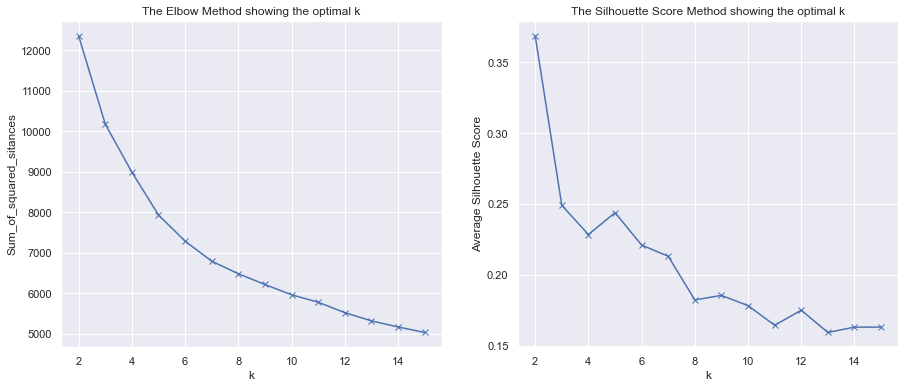

In [32]:
figsize(15, 6)
plt.subplot(1, 2, 1)
plot_elbow_plot(X, scaler=poss_weights_scaler, sample_weight=poss_weights)
plt.subplot(1, 2, 2)
plot_silhouette_score(X, scaler=poss_weights_scaler, sample_weight=poss_weights)

In [33]:
# Choose k = 6
player_km_optimal = KMeans(n_clusters=6, random_state=42, init='k-means++')
player_km_optimal.fit(poss_weights_scaler.transform(X), sample_weight=poss_weights)
# player_km_optimal.fit(poss_weights_scaler.transform(X))
player_cluster_pred = player_km_optimal.predict(poss_weights_scaler.transform(X))

In [34]:
df['player_cluster'] = player_cluster_pred
df.groupby('player_cluster').count()['Player']

player_cluster
0    146
1    284
2    488
3    203
4    208
5    455
Name: Player, dtype: int64

## Clusters Overview

### Possession Distribution

- Cluster 0 [146 Players]: 
    - Highest average OBPM: +2.49
    - Primary attacker role 
        - Second highest p&r ball handler poss%
        - Highest iso poss%
    - Low cut poss%
- Cluster 3 [203 Players]:
    - The other cluster with a +ve OBPM in average
    - Big man role 
        - Second highest p&r man poss%
        - Highest post-up poss%
        - Skilled with high spot-up poss%
- Cluster 4 [208 Players]:
    - Wing role
        - Highest off-screen poss%
        - Highest hand off poss%
        - Second highest spot up poss%
- Cluster 5 [455 Players]:
    - Ballhandling role
        - Highest p&r ball handler poss%
    - Shot spot up tho
- Cluster 1 [284 Players]:
    - Highest cut poss%
    - Big man role
        - Highest p&r man poss%
        - Crash the board a lot with the highest putback%
        - Second highest post-up poss%
- Cluster 2 [488 Players]
    - Wing role
        - Highest spot up poss%
        - Highest transition poss%

In [35]:
cluster_res = df.groupby('player_cluster')[['usg_pct', 'obpm'] + poss_weights_cols]\
                .mean().sort_values('obpm', ascending=False)
cluster_res['obpm'] = cluster_res['obpm'].apply(lambda x: f'{x:.2f}')
# cluster_res['dbpm'] = cluster_res['dbpm'].apply(lambda x: f'{x:.2f}')
cluster_res['usg_pct'] = cluster_res['usg_pct'].apply(lambda x: f'{x:.1f}%')
for col in cluster_res.columns:
    if '%' in col:
        cluster_res[col] = cluster_res[col].apply(lambda x: f'{x:.2%}')
cluster_res.T

player_cluster,0,3,4,5,1,2
usg_pct,26.5%,22.8%,19.4%,21.6%,17.0%,16.1%
obpm,2.49,0.98,-0.25,-0.28,-0.40,-1.44
Spot Up_Poss%,14.67%,19.43%,26.24%,19.47%,9.29%,36.10%
P&R Ball Handler_Poss%,26.84%,1.97%,14.74%,35.56%,0.33%,8.47%
Transition_Poss%,14.84%,9.71%,16.25%,16.13%,8.49%,19.37%
Cut_Poss%,3.03%,9.36%,4.17%,2.72%,21.81%,7.29%
Offensive Rebounds (put backs)_Poss%,2.19%,7.96%,1.72%,1.77%,16.52%,4.92%
Hand Off_Poss%,4.28%,1.26%,11.81%,6.53%,0.30%,4.41%
P&R Roll Man_Poss%,1.80%,16.78%,1.06%,0.44%,22.19%,4.14%
Isolation_Poss%,16.90%,5.29%,3.31%,7.40%,1.90%,3.21%


### Position Distribution

#### Cluster 0

In [36]:
df[df['player_cluster'] == 0].groupby('pos').count()['Player']

pos
PF    31
PG    45
SF    39
SG    31
Name: Player, dtype: int64

In [37]:
set(df[(df['player_cluster'] == 0) & (df['pos'] == 'PF')]['Player'])

{'Brandon Ingram',
 'Carmelo Anthony',
 'DeMar DeRozan',
 'Eric Paschall',
 'Giannis Antetokounmpo',
 'Harrison Barnes',
 'Jabari Parker',
 'James Johnson',
 'Jayson Tatum',
 'Julius Randle',
 'Kevin Durant',
 'LeBron James',
 'Marcus Morris',
 'Michael Beasley',
 'Pascal Siakam',
 'Rudy Gay',
 'Tobias Harris'}

#### Cluster 3

In [38]:
df[df['player_cluster'] == 3].groupby('pos').count()['Player']

pos
C     98
PF    99
PG     3
SF     3
Name: Player, dtype: int64

In [39]:
set(df[(df['player_cluster'] == 3) & (df['pos'] == 'PG')]['Player'])

{'Ben Simmons', 'Evan Turner', 'Shaun Livingston'}

In [40]:
set(df[(df['player_cluster'] == 3) & (df['pos'] == 'SF')]['Player'])

{'Harrison Barnes', 'MauriceHarkless', 'Rondae Hollis-Jefferson'}

#### Cluster 4

In [41]:
df[df['player_cluster'] == 4].groupby('pos').count()['Player']

pos
PF      8
PG     10
SF     47
SG    143
Name: Player, dtype: int64

In [42]:
set(df[(df['player_cluster'] == 4) & (df['pos'] == 'PF')]['Player'])

{'Davis Bertans',
 'Doug McDermott',
 'Gordon Hayward',
 'JoeIngles',
 'Kevin Knox II',
 'Tobias Harris'}

#### Cluster 5

In [43]:
df[df['player_cluster'] == 5].groupby('pos').count()['Player']

pos
PF      6
PG    285
SF     36
SG    128
Name: Player, dtype: int64

In [44]:
df[(df['player_cluster'] == 5) & (df['pos'] == 'PF')]

,Player,Overall_Poss,Overall_Points,Overall_PPP,Overall_Rank,Overall_Rating,Team,Spot Up_Poss,Spot Up_Points,Spot Up_PPP,...,height,weight,birth_date,birth_country,years_experience,college,height_cm,weight_kg,player_alt_alt,player_cluster
823,Tobias Harris,483,492,1.019,69,Very Good,Philadelphia 76ers,88.0,98.0,1.114,...,6-8,226.0,"July 15, 1992",us,7,Tennessee,203.2,102.5,tobiasharris,5
1097,JoeIngles,740,707,0.955,48,Average,Utah Jazz,147.0,149.0,1.014,...,6-8,220.0,"October 2, 1987",au,5,NaN,203.2,99.8,joeingles,5
1530,Tobias Harris,1118,1208,1.081,81,Very Good,Philadelphia 76ers,163.0,170.0,1.043,...,6-8,226.0,"July 15, 1992",us,9,Tennessee,203.2,102.5,tobiasharris,5
1541,Andrew Wiggins,1287,1320,1.026,64,Good,Golden State Warriors,283.0,276.0,0.975,...,6-7,197.0,"February 23, 1995",ca,6,Kansas,200.7,89.4,andrewwiggins,5
1569,Aleksej Pokusevski,527,367,0.696,6,Poor,Oklahoma City Thunder,180.0,135.0,0.750,...,7-0,190.0,"December 26, 2001",rs,R,NaN,213.4,86.2,aleksejpokusevski,5
1774,Aaron Gordon,408,364,0.890,25,Below Average,Orlando Magic,65.0,72.0,1.108,...,6-8,235.0,"September 16, 1995",us,6,Arizona,203.2,106.6,aarongordon,5


In [45]:
df[(df['player_cluster'] == 5) & (df['pos'] == 'SF')]

,Player,Overall_Poss,Overall_Points,Overall_PPP,Overall_Rank,Overall_Rating,Team,Spot Up_Poss,Spot Up_Points,Spot Up_PPP,...,height,weight,birth_date,birth_country,years_experience,college,height_cm,weight_kg,player_alt_alt,player_cluster
82,KentBazemore,923,801,0.868,28,Below Average,Atlanta Hawks,235.0,209.0,0.889,...,6-4,195.0,"July 1, 1989",us,4,Old Dominion,193.0,88.5,kentbazemore,5
276,Khris Middleton,434,421,0.970,60,Good,Milwaukee Bucks,108.0,127.0,1.176,...,6-7,222.0,"August 12, 1991",us,4,Texas A&M,200.7,100.7,khrismiddleton,5
300,Tyreke Evans,289,248,0.858,25,Below Average,New Orleans Pelicans,38.0,30.0,0.789,...,6-6,220.0,"September 19, 1989",us,7,Memphis,198.1,99.8,tyrekeevans,5
337,Justise Winslow,276,196,0.703,6,Poor,Miami Heat,66.0,38.0,0.576,...,6-6,222.0,"March 26, 1996",us,1,Duke,198.1,100.7,justisewinslow,5
352,Dillon Brooks,970,898,0.926,41,Average,Memphis Grizzlies,250.0,273.0,1.092,...,6-7,225.0,"January 22, 1996",ca,R,Oregon,200.7,102.1,dillonbrooks,5
611,Caris LeVert,965,858,0.889,31,Average,Brooklyn Nets,198.0,198.0,1.000,...,6-6,205.0,"August 25, 1994",us,1,Michigan,198.1,93.0,carislevert,5
620,Josh Jackson,1202,1012,0.842,21,Below Average,Phoenix Suns,208.0,154.0,0.740,...,6-8,207.0,"February 10, 1997",us,R,Kansas,203.2,93.9,joshjackson,5
631,Khris Middleton,1600,1651,1.032,78,Very Good,Milwaukee Bucks,331.0,357.0,1.079,...,6-7,222.0,"August 12, 1991",us,5,Texas A&M,200.7,100.7,khrismiddleton,5
640,AndrewWiggins,1578,1452,0.920,39,Average,Minnesota Timberwolves,329.0,296.0,0.900,...,6-7,197.0,"February 23, 1995",ca,3,Kansas,200.7,89.4,andrewwiggins,5
718,Chandler Parsons,225,187,0.831,16,Below Average,Memphis Grizzlies,81.0,63.0,0.778,...,6-9,230.0,"October 25, 1988",us,7,Florida,205.7,104.3,chandlerparsons,5


#### Cluster 1

In [46]:
df[df['player_cluster'] == 1].groupby('pos').count()['Player']

pos
C     242
PF     39
PG      1
SF      1
SG      1
Name: Player, dtype: int64

In [47]:
df[(df['player_cluster'] == 1) & (df['pos'] == 'PG')]

,Player,Overall_Poss,Overall_Points,Overall_PPP,Overall_Rank,Overall_Rating,Team,Spot Up_Poss,Spot Up_Points,Spot Up_PPP,...,height,weight,birth_date,birth_country,years_experience,college,height_cm,weight_kg,player_alt_alt,player_cluster
841,Shaun Livingston,271,258,0.952,46,Average,Golden State Warriors,11.0,13.0,1.182,...,6-7,192.0,"September 11, 1985",us,13,NaN,200.7,87.1,shaunlivingston,1


In [48]:
df[(df['player_cluster'] == 1) & (df['pos'] == 'SG')]

,Player,Overall_Poss,Overall_Points,Overall_PPP,Overall_Rank,Overall_Rating,Team,Spot Up_Poss,Spot Up_Points,Spot Up_PPP,...,height,weight,birth_date,birth_country,years_experience,college,height_cm,weight_kg,player_alt_alt,player_cluster
512,Andre Roberson,209,194,0.928,41,Average,Oklahoma City Thunder,43.0,28.0,0.651,...,6-7,210.0,"December 4, 1991",us,4,Colorado,200.7,95.3,andreroberson,1


In [49]:
df[(df['player_cluster'] == 1) & (df['pos'] == 'SF')]

,Player,Overall_Poss,Overall_Points,Overall_PPP,Overall_Rank,Overall_Rating,Team,Spot Up_Poss,Spot Up_Points,Spot Up_PPP,...,height,weight,birth_date,birth_country,years_experience,college,height_cm,weight_kg,player_alt_alt,player_cluster
485,Omri Casspi,274,300,1.095,91,Excellent,Golden State Warriors,38.0,41.0,1.079,...,6-9,225.0,"June 22, 1988",il,8,NaN,205.7,102.1,omricasspi,1


#### Cluster 2

In [50]:
df[df['player_cluster'] == 2].groupby('pos').count()['Player']

pos
C      10
PF    160
PG     33
SF    182
SG    103
Name: Player, dtype: int64

In [51]:
df[(df['player_cluster'] == 2) & (df['pos'] == 'C')]

,Player,Overall_Poss,Overall_Points,Overall_PPP,Overall_Rank,Overall_Rating,Team,Spot Up_Poss,Spot Up_Points,Spot Up_PPP,...,height,weight,birth_date,birth_country,years_experience,college,height_cm,weight_kg,player_alt_alt,player_cluster
152,Channing Frye,606,674,1.112,95,Excellent,Cleveland Cavaliers,241.0,307.0,1.274,...,7-0,255.0,"May 17, 1983",us,10,Arizona,213.4,115.7,channingfrye,2
998,Brook Lopez,923,1009,1.093,88,Excellent,Milwaukee Bucks,361.0,401.0,1.111,...,7-0,282.0,"April 1, 1988",us,10,Stanford,213.4,127.9,brooklopez,2
1308,Robert Covington,269,255,0.948,45,Average,Houston Rockets,153.0,132.0,0.863,...,6-7,209.0,"December 14, 1990",us,6,Tennessee State,200.7,94.8,robertcovington,2
1382,Nicolo Melli,402,395,0.983,55,Good,New Orleans Pelicans,156.0,161.0,1.032,...,6-9,236.0,"January 26, 1991",it,R,NaN,205.7,107.0,nicolomelli,2
1412,Kelly Olynyk,514,549,1.068,82,Very Good,Miami Heat,174.0,198.0,1.138,...,6-11,240.0,"April 19, 1991",ca,6,Gonzaga,210.8,108.9,kellyolynyk,2
1414,Meyers Leonard,283,309,1.092,86,Excellent,Miami Heat,113.0,118.0,1.044,...,7-0,260.0,"February 27, 1992",us,7,Illinois,213.4,117.9,meyersleonard,2
1576,Mike Muscala,299,339,1.134,90,Excellent,Oklahoma City Thunder,120.0,140.0,1.167,...,6-10,240.0,"July 1, 1991",us,7,Bucknell,208.3,108.9,mikemuscala,2
1679,Jeff Green,656,750,1.143,91,Excellent,Brooklyn Nets,247.0,291.0,1.178,...,6-8,235.0,"August 28, 1986",us,12,Georgetown,203.2,106.6,jeffgreen,2
1740,Myles Turner,564,592,1.050,72,Very Good,Indiana Pacers,199.0,196.0,0.985,...,6-11,250.0,"March 24, 1996",us,5,Texas,210.8,113.4,mylesturner,2
1763,Kelly Olynyk,449,432,0.962,45,Average,Miami Heat,151.0,139.0,0.921,...,6-11,240.0,"April 19, 1991",ca,7,Gonzaga,210.8,108.9,kellyolynyk,2


In [52]:
df[(df['player_cluster'] == 2) & (df['pos'] == 'PG')]

,Player,Overall_Poss,Overall_Points,Overall_PPP,Overall_Rank,Overall_Rating,Team,Spot Up_Poss,Spot Up_Points,Spot Up_PPP,...,height,weight,birth_date,birth_country,years_experience,college,height_cm,weight_kg,player_alt_alt,player_cluster
187,Devin Harris,458,437,0.954,55,Good,Dallas Mavericks,131.0,147.0,1.122,...,6-3,185.0,"February 27, 1983",us,12,Wisconsin,190.5,83.9,devinharris,2
481,Shaun Livingston,424,394,0.929,43,Average,Golden State Warriors,18.0,21.0,1.167,...,6-7,192.0,"September 11, 1985",us,12,NaN,200.7,87.1,shaunlivingston,2
497,Tyrone Wallace,330,291,0.882,29,Below Average,Los Angeles Clippers,80.0,71.0,0.888,...,6-5,198.0,"June 10, 1994",us,R,California,195.6,89.8,tyronewallace,2
558,Devin Harris,381,373,0.979,59,Good,Dallas Mavericks,99.0,108.0,1.091,...,6-3,185.0,"February 27, 1983",us,13,Wisconsin,190.5,83.9,devinharris,2
571,Devin Harris,220,222,1.009,70,Very Good,Denver Nuggets,79.0,87.0,1.101,...,6-3,185.0,"February 27, 1983",us,13,Wisconsin,190.5,83.9,devinharris,2
648,Tyus Jones,421,416,0.986,61,Good,Minnesota Timberwolves,125.0,122.0,0.976,...,6-0,196.0,"May 10, 1996",us,2,Duke,182.9,88.9,tyusjones,2
739,Lonzo Ball,581,465,0.800,13,Poor,Los Angeles Lakers,123.0,98.0,0.797,...,6-6,190.0,"October 27, 1997",us,1,UCLA,198.1,86.2,lonzoball,2
762,Tomas Satoransky,724,709,0.979,56,Good,Washington Wizards,210.0,235.0,1.119,...,6-7,210.0,"October 30, 1991",cz,2,NaN,200.7,95.3,tomassatoransky,2
850,Tyrone Wallace,280,218,0.779,11,Poor,Los Angeles Clippers,60.0,59.0,0.983,...,6-5,198.0,"June 10, 1994",us,1,California,195.6,89.8,tyronewallace,2
912,Devin Harris,462,428,0.926,37,Average,Dallas Mavericks,158.0,163.0,1.032,...,6-3,185.0,"February 27, 1983",us,14,Wisconsin,190.5,83.9,devinharris,2


### Height & Weight Distribution

In [53]:
cluster_dict = {0: 'Lead Attacker (PnR Handler+Iso)', 
                3: 'Skilled Big Man (PnR Man+Post-Up+Spot Up)', 
                4: 'Shooter (Spot Up+Off-Screen+Hand Off)',
                5: 'Ballhandler (PnR Handler+Spot Up)',
                1: 'Secondary Big Man (Cut+PnR Man+Putback)',
                2: 'Wing (Spot-Up+Transition)'}

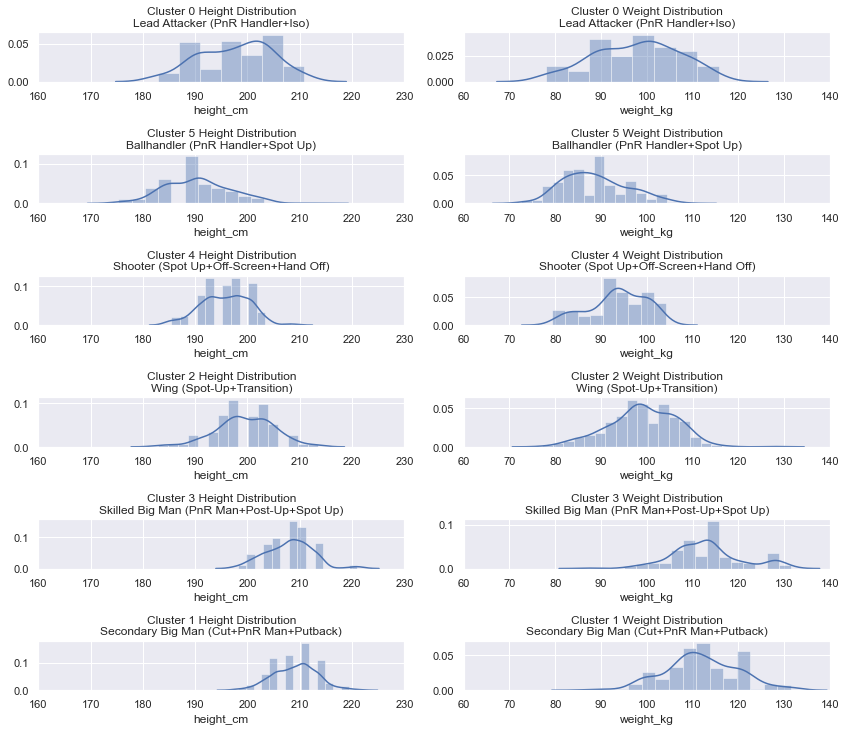

In [54]:
figsize(12, 20)
for i, cluster in enumerate([0, 5, 4, 2, 3, 1], 0):
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['height_cm'])
    plt.title(f'Cluster {cluster} Height Distribution\n{cluster_dict[cluster]}')
    plt.xlim(160, 230)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['weight_kg'])
    plt.title(f'Cluster {cluster} Weight Distribution\n{cluster_dict[cluster]}')
    plt.xlim(60, 140)
plt.tight_layout()

### Usage & Shooting Distribution

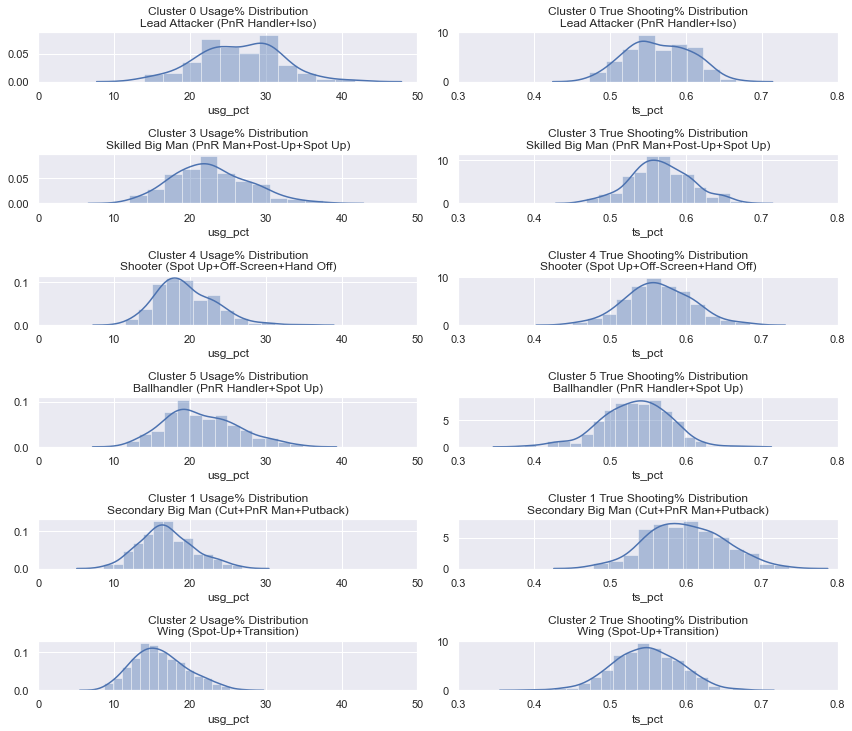

In [55]:
figsize(12, 20)
for i, cluster in enumerate([0, 3, 4, 5, 1, 2], 0):
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['usg_pct'])
    plt.title(f'Cluster {cluster} Usage% Distribution\n{cluster_dict[cluster]}')
    plt.xlim(0, 50)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['ts_pct'])
    plt.title(f'Cluster {cluster} True Shooting% Distribution\n{cluster_dict[cluster]}')
    plt.xlim(0.3, 0.8)
plt.tight_layout()

### PPP & OBPM Distribution

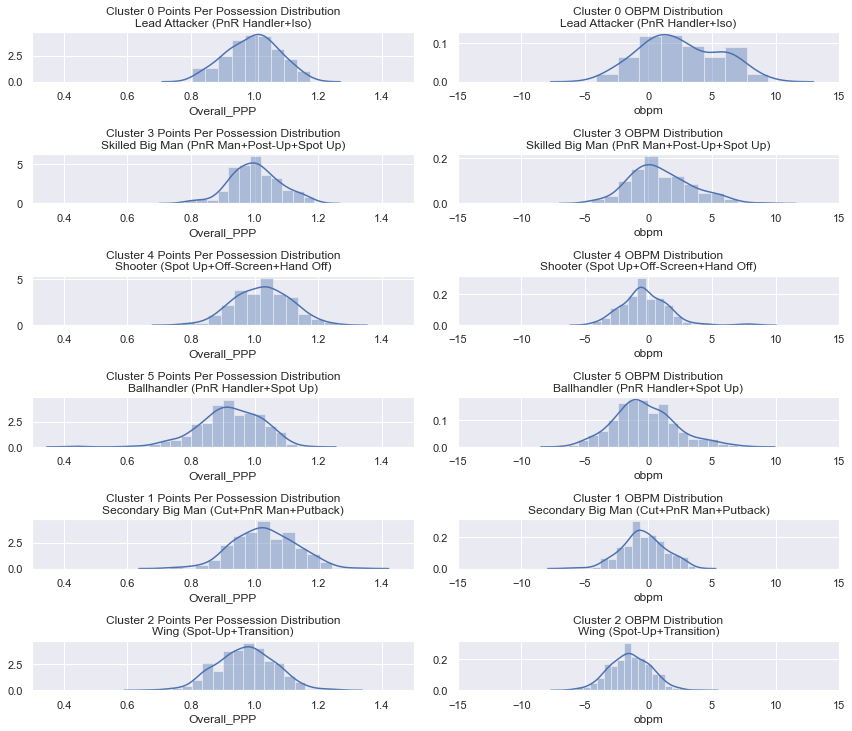

In [56]:
figsize(12, 20)
for i, cluster in enumerate([0, 3, 4, 5, 1, 2], 0):
    plt.subplot(12, 2, i*2+1)
    sns.distplot(df[df['player_cluster'] == cluster]['Overall_PPP'])
    plt.title(f'Cluster {cluster} Points Per Possession Distribution\n{cluster_dict[cluster]}')
    plt.xlim(0.3, 1.5)
    plt.subplot(12, 2, i*2+2)
    sns.distplot(df[df['player_cluster'] == cluster]['obpm'])
    plt.title(f'Cluster {cluster} OBPM Distribution\n{cluster_dict[cluster]}')
    plt.xlim(-15, 15)
plt.tight_layout()

0 Lead Attacker (PnR Handler+Iso)
R-squared: 62.0%
RMSE: 1.875
3 Skilled Big Man (PnR Man+Post-Up+Spot Up)
R-squared: 43.2%
RMSE: 1.829
4 Shooter (Spot Up+Off-Screen+Hand Off)
R-squared: 31.3%
RMSE: 1.567
5 Ballhandler (PnR Handler+Spot Up)
R-squared: 39.6%
RMSE: 1.883
1 Secondary Big Man (Cut+PnR Man+Putback)
R-squared: 14.6%
RMSE: 1.559
2 Wing (Spot-Up+Transition)
R-squared: 9.2%
RMSE: 1.517


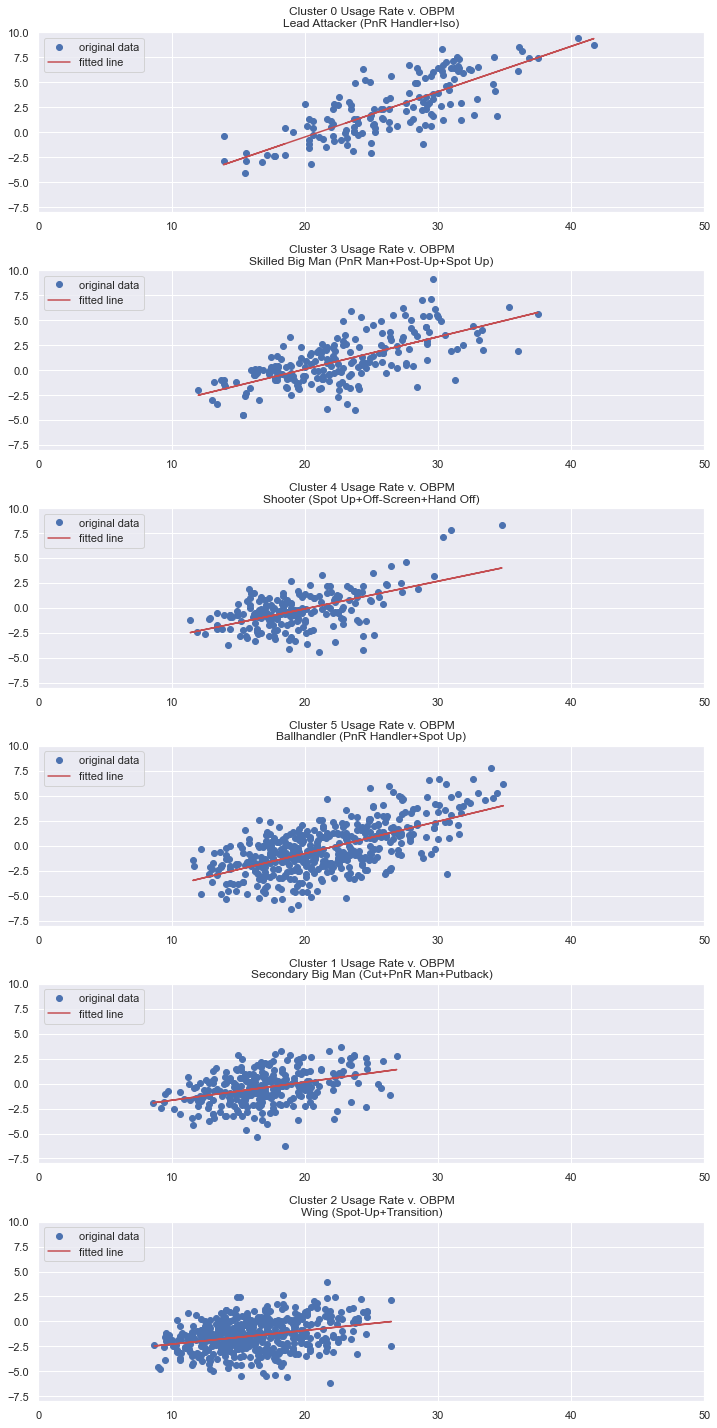

In [57]:
figsize(10, 20)
for i, cluster in enumerate([0, 3, 4, 5, 1, 2], 0):
    plt.subplot(6, 1, i+1)
    cluster_cond = df['player_cluster'] == cluster
    x = df[cluster_cond]['usg_pct'].values
    y = df[cluster_cond]['obpm'].values
    res = linregress(x, y)
    y_pred = res.intercept + res.slope*x
    print(cluster, cluster_dict[cluster])
    print(f'R-squared: {res.rvalue ** 2:.1%}')
    print(f'RMSE: {np.sqrt(mean_squared_error(y, y_pred)):.3f}')

    plt.plot(x, y, 'o', label='original data')
    plt.plot(x, y_pred, 'r', label='fitted line')
    plt.title(f'Cluster {cluster} Usage Rate v. OBPM\n{cluster_dict[cluster]}')
    plt.legend(loc='upper left')
    plt.xlim(0, 50)
    plt.ylim(-8, 10)
plt.tight_layout()

In [58]:
# cluster_cond = df['player_cluster'] == 3
# df[cluster_cond].sort_values('obpm', ascending=False).head()[cols]

In [59]:
# cluster_cond = df['player_cluster'] == 3
# df[(cluster_cond) & (df['usg_pct'] > 30) & (df['obpm'] < 0)].sort_values('obpm', ascending=False).head()[cols]

In [60]:
# cluster_cond = df['player_cluster'] == 4
# df[(cluster_cond)].sort_values('obpm', ascending=False).head(3)[cols]

In [61]:
# cluster_cond = df['player_cluster'] == 5
# df[(cluster_cond) & (df['usg_pct'] > 30) & (df['obpm'] < 0)].sort_values('obpm', ascending=False).head()[cols]

In [62]:
# cluster_cond = df['player_cluster'] == 2
# df[(cluster_cond) & (df['usg_pct'] > 25)].sort_values('obpm', ascending=False).head()[cols]

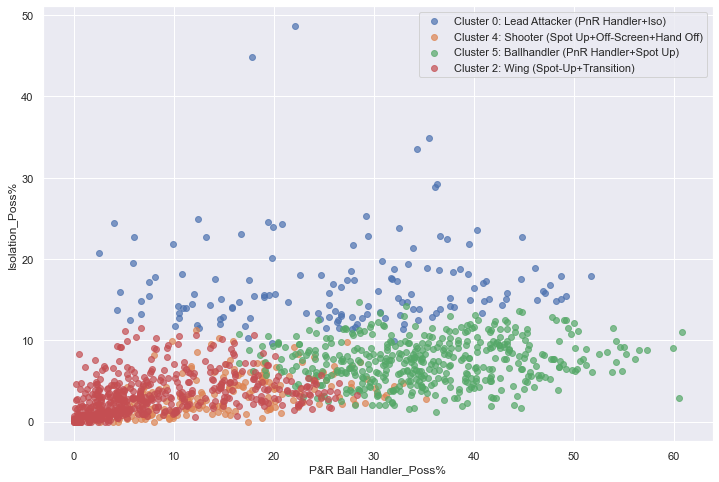

In [63]:
figsize(12, 8)
for cluster in [0, 4, 5, 2]:
    cluster_cond = df['player_cluster'] == cluster
    x = df[cluster_cond]['P&R Ball Handler_Poss%'].values * 100
    y = df[cluster_cond]['Isolation_Poss%'].values * 100

    plt.scatter(x, y, label=f'Cluster {cluster}: {cluster_dict[cluster]}', alpha=0.7)
    plt.xlabel('P&R Ball Handler_Poss%')
    plt.ylabel('Isolation_Poss%')
    plt.legend()

In [64]:
# df[df['Isolation_Poss%']>0.3][cols + ['Isolation_Poss%', 'P&R Ball Handler_Poss%']]

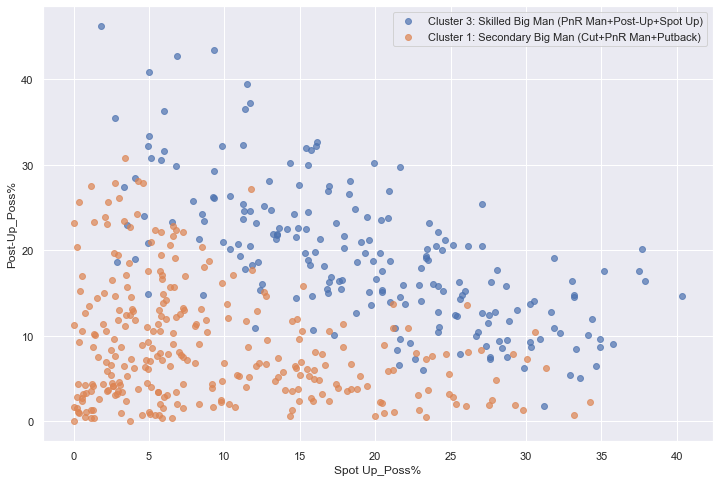

In [65]:
figsize(12, 8)
for cluster in [3, 1]:
    cluster_cond = df['player_cluster'] == cluster
    x = df[cluster_cond]['Spot Up_Poss%'].values * 100
    y = df[cluster_cond]['Post-Up_Poss%'].values * 100

    plt.scatter(x, y, label=f'Cluster {cluster}: {cluster_dict[cluster]}', alpha=0.7)
    plt.xlabel('Spot Up_Poss%')
    plt.ylabel('Post-Up_Poss%')
    plt.legend()

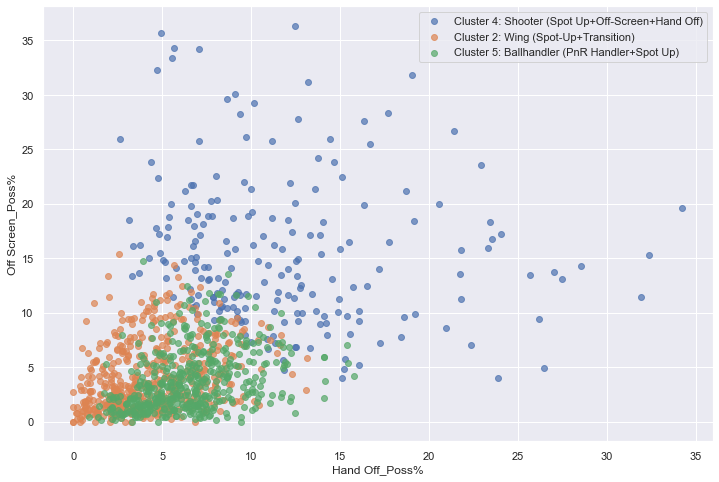

In [66]:
figsize(12, 8)
for cluster in [4, 2, 5]:
    cluster_cond = df['player_cluster'] == cluster
    x = df[cluster_cond]['Hand Off_Poss%'].values * 100
    y = df[cluster_cond]['Off Screen_Poss%'].values * 100

    plt.scatter(x, y, label=f'Cluster {cluster}: {cluster_dict[cluster]}', alpha=0.7)
    plt.xlabel('Hand Off_Poss%')
    plt.ylabel('Off Screen_Poss%')
    plt.legend()

## Soft Labeling

In [67]:
rf = RandomForestClassifier(random_state=42)
rf.fit(poss_weights_scaler.transform(X), df['player_cluster'].values)
df['player_cluster_pred'] = rf.predict(poss_weights_scaler.transform(X))

In [68]:
player_cluster_pred = rf.predict_proba(poss_weights_scaler.transform(X))
df['cluster_probs'] = [probs for probs in player_cluster_pred]
df['cluster_prob'] = df.apply(lambda x: x['cluster_probs'][x['player_cluster']],
                              axis=1)

<AxesSubplot:>

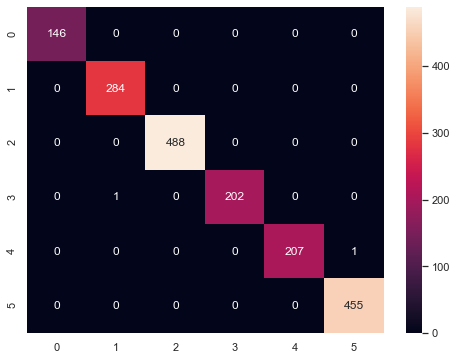

In [69]:
figsize(8, 6)
sns.heatmap(confusion_matrix(df['player_cluster'].values, 
                             df['player_cluster_pred'].values), 
            annot=True, fmt='d')

In [70]:
cols = ['player', 'player_cluster', 'cluster_prob', 'cluster_probs',
        'season', 'team', 'mp', 'usg_pct', 'ts_pct', 'Overall_PPP', 
        'obpm', 'dbpm', 'bpm']

In [71]:
df[df['player_cluster'] != df['player_cluster_pred']][cols + ['player_cluster_pred']]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster_pred
731,Grayson Allen,4,0.4,"[0.0, 0.0, 0.0, 0.0, 0.4, 0.6]",2018.0,Utah Jazz,416.0,24.4,0.516,0.883,-4.2,-2.1,-6.3,5
1639,Thaddeus Young,3,0.5,"[0.0, 0.5, 0.0, 0.5, 0.0, 0.0]",2020.0,Chicago Bulls,1652.0,22.3,0.578,0.977,1.9,1.4,3.3,1


<AxesSubplot:>

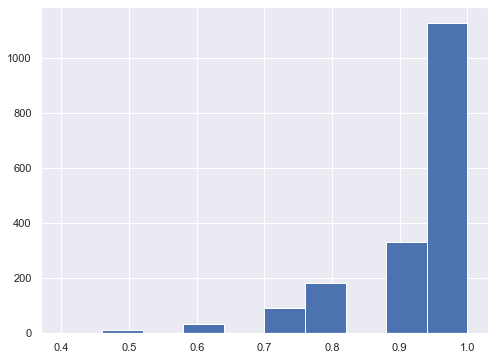

In [72]:
df['cluster_prob'].hist()

## Best & Worst Players by Clusters

### 0

In [73]:
cluster = 0
print(cluster, cluster_dict[cluster])

0 Lead Attacker (PnR Handler+Iso)


In [74]:
for row in df[df['player_cluster'] == 0][['player', 'season', 
                                          'team', 'obpm']].sort_values('obpm', ascending=False).values:
    print(row)

['James Harden' 2018.0 'Houston Rockets' 9.4]
['Russell Westbrook' 2016.0 'Oklahoma City Thunder' 8.7]
['James Harden' 2017.0 'Houston Rockets' 8.5]
['Damian Lillard' 2019.0 'Portland Trail Blazers' 8.3]
['James Harden' 2019.0 'Houston Rockets' 8.1]
['James Harden' 2016.0 'Houston Rockets' 7.5]
['Damian Lillard' 2020.0 'Portland Trail Blazers' 7.5]
['Giannis Antetokounmpo' 2019.0 'Milwaukee Bucks' 7.4]
['Luka Dončić' 2019.0 'Dallas Mavericks' 7.4]
['LeBron James' 2017.0 'Cleveland Cavaliers' 7.3]
['Kawhi Leonard' 2016.0 'San Antonio Spurs' 7.1]
['Damian Lillard' 2017.0 'Portland Trail Blazers' 7.0]
['Kevin Durant' 2016.0 'Golden State Warriors' 6.7]
['Kevin Durant' 2017.0 'Golden State Warriors' 6.7]
['LeBron James' 2019.0 'Los Angeles Lakers' 6.6]
['Kawhi Leonard' 2019.0 'Los Angeles Clippers' 6.5]
['LeBron James' 2016.0 'Cleveland Cavaliers' 6.4]
['LeBron James' 2018.0 'Los Angeles Lakers' 6.4]
['Kyrie Irving' 2017.0 'Boston Celtics' 6.4]
['James Harden' 2020.0 'Brooklyn Nets' 6.4]
[

In [75]:
temp = df[df['player_cluster'] == 0].groupby('player')['season'].apply(set).reset_index()
temp['n_season'] = temp['season'].apply(len)
temp.sort_values('n_season', ascending=False)

,player,season,n_season
51,Russell Westbrook,"{2016.0, 2017.0, 2018.0, 2019.0, 2020.0}",5
24,James Harden,"{2016.0, 2017.0, 2018.0, 2019.0, 2020.0}",5
48,Paul George,"{2016.0, 2017.0, 2018.0, 2019.0, 2020.0}",5
40,LeBron James,"{2016.0, 2017.0, 2018.0, 2019.0, 2020.0}",5
7,Chris Paul,"{2016.0, 2017.0, 2018.0, 2019.0, 2020.0}",5
20,Giannis Antetokounmpo,"{2016.0, 2017.0, 2018.0, 2019.0, 2020.0}",5
11,DeMar DeRozan,"{2016.0, 2017.0, 2018.0, 2019.0, 2020.0}",5
38,Kyrie Irving,"{2016.0, 2017.0, 2018.0, 2020.0}",4
27,Jeff Teague,"{2016.0, 2017.0, 2019.0, 2020.0}",4
34,Kawhi Leonard,"{2016.0, 2018.0, 2019.0, 2020.0}",4


In [76]:
df[df['player_cluster'] == 0].sort_values('obpm', ascending=False)[cols].head(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
945,James Harden,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2018.0,Houston Rockets,2867.0,40.5,0.616,1.073,9.4,1.6,11.0
136,Russell Westbrook,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2016.0,Oklahoma City Thunder,2802.0,41.7,0.554,0.936,8.7,2.4,11.1
586,James Harden,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2017.0,Houston Rockets,2551.0,36.1,0.619,1.064,8.5,1.4,9.9
1396,Damian Lillard,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2019.0,Portland Trail Blazers,2474.0,30.3,0.627,1.130,8.3,-0.9,7.5
1300,James Harden,0,0.9,"[0.9, 0.0, 0.0, 0.0, 0.0, 0.1]",2019.0,Houston Rockets,2483.0,36.3,0.626,1.093,8.1,1.6,9.6
220,James Harden,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2016.0,Houston Rockets,2947.0,34.2,0.613,1.007,7.5,1.2,8.7
1745,Damian Lillard,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2020.0,Portland Trail Blazers,2398.0,31.4,0.623,1.107,7.5,-1.3,6.3
1345,Giannis Antetokounmpo,0,0.9,"[0.9, 0.0, 0.0, 0.1, 0.0, 0.0]",2019.0,Milwaukee Bucks,1917.0,37.5,0.613,1.072,7.4,4.1,11.5
1265,Luka Dončić,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2019.0,Dallas Mavericks,2047.0,36.8,0.585,1.007,7.4,1.0,8.4
513,LeBron James,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2017.0,Cleveland Cavaliers,3026.0,31.6,0.621,1.050,7.3,1.4,8.7


In [77]:
df[df['player_cluster'] == 0].sort_values('obpm', ascending=False)[cols].tail(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
688,Dion Waiters,0,0.8,"[0.8, 0.0, 0.0, 0.0, 0.0, 0.2]",2017.0,Miami Heat,918.0,25.0,0.487,0.836,-2.1,-1.4,-3.5
376,Joe Johnson,0,0.9,"[0.9, 0.0, 0.0, 0.1, 0.0, 0.0]",2017.0,Utah Jazz,700.0,17.2,0.492,0.873,-2.3,-0.3,-2.6
319,Evan Turner,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2016.0,Portland Trail Blazers,1658.0,18.5,0.491,0.842,-2.3,-0.1,-2.5
1067,James Johnson,0,0.8,"[0.8, 0.1, 0.0, 0.1, 0.0, 0.0]",2018.0,Miami Heat,1164.0,17.8,0.522,0.882,-2.4,1.1,-1.2
1527,Jeff Teague,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2020.0,Boston Celtics,616.0,17.7,0.542,0.914,-2.4,-0.3,-2.7
951,Austin Rivers,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2018.0,Houston Rockets,1345.0,13.9,0.511,0.947,-2.9,-0.9,-3.8
673,Evan Turner,0,0.7,"[0.7, 0.0, 0.0, 0.2, 0.0, 0.1]",2017.0,Portland Trail Blazers,2034.0,15.6,0.520,0.896,-2.9,0.4,-2.5
27,Brandon Ingram,0,0.9,"[0.9, 0.0, 0.0, 0.0, 0.0, 0.1]",2016.0,Los Angeles Lakers,2279.0,16.8,0.474,0.823,-3.0,-1.4,-4.4
1235,Kevin Porter Jr.,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2019.0,Cleveland Cavaliers,1162.0,20.5,0.535,0.892,-3.2,-0.6,-3.8
772,Austin Rivers,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2018.0,Washington Wizards,683.0,15.5,0.490,0.840,-4.1,-1.2,-5.3


### 3

In [78]:
cluster = 3
print(cluster, cluster_dict[cluster])

3 Skilled Big Man (PnR Man+Post-Up+Spot Up)


In [79]:
df[df['player_cluster'] == 3].sort_values('obpm', ascending=False)[cols].head(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
1627,Nikola Jokić,3,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2020.0,Denver Nuggets,2488.0,29.6,0.647,1.126,9.1,3.0,12.1
1020,Anthony Davis,3,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2018.0,New Orleans Pelicans,1850.0,29.5,0.597,1.092,7.1,2.3,9.4
1358,Karl-Anthony Towns,3,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2019.0,Minnesota Timberwolves,1187.0,28.8,0.642,1.131,7.0,0.8,7.8
1529,Joel Embiid,3,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2020.0,Philadelphia 76ers,1585.0,35.3,0.636,1.115,6.3,1.2,7.5
917,Nikola Jokić,3,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2018.0,Denver Nuggets,2504.0,27.4,0.589,0.999,6.2,2.9,9.1
1721,Zion Williamson,3,0.9,"[0.1, 0.0, 0.0, 0.9, 0.0, 0.0]",2020.0,New Orleans Pelicans,2026.0,29.8,0.649,1.153,6.1,-0.3,5.8
194,Nikola Jokić,3,0.7,"[0.0, 0.3, 0.0, 0.7, 0.0, 0.0]",2016.0,Denver Nuggets,2038.0,23.5,0.640,1.089,5.9,1.4,7.3
158,DeMarcus Cousins,3,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2016.0,Sacramento Kings,1891.0,37.5,0.562,0.981,5.6,1.6,7.2
1769,Nikola Vučević,3,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2020.0,Orlando Magic,1500.0,29.9,0.565,1.041,5.5,0.4,5.9
281,Karl-Anthony Towns,3,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2016.0,Minnesota Timberwolves,3030.0,27.5,0.618,1.099,5.5,-0.7,4.7


In [80]:
df[df['player_cluster'] == 3].sort_values('obpm', ascending=False)[cols].tail(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
322,Meyers Leonard,3,0.8,"[0.0, 0.0, 0.2, 0.8, 0.0, 0.0]",2016.0,Portland Trail Blazers,1222.0,15.5,0.507,0.926,-2.6,-0.6,-3.3
913,Dirk Nowitzki,3,0.9,"[0.0, 0.0, 0.1, 0.9, 0.0, 0.0]",2018.0,Dallas Mavericks,795.0,22.5,0.469,0.908,-2.7,-1.2,-3.9
122,Shaun Livingston,3,0.7,"[0.1, 0.0, 0.1, 0.7, 0.1, 0.0]",2016.0,Golden State Warriors,1345.0,13.0,0.568,0.965,-3.0,0.5,-2.5
1353,Robin Lopez,3,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2019.0,Milwaukee Bucks,958.0,16.6,0.554,0.927,-3.0,0.4,-2.6
884,Harry Giles,3,0.9,"[0.0, 0.1, 0.0, 0.9, 0.0, 0.0]",2018.0,Sacramento Kings,820.0,23.2,0.526,0.881,-3.4,0.4,-3.0
994,Dragan Bender,3,0.5,"[0.0, 0.1, 0.4, 0.5, 0.0, 0.0]",2018.0,Phoenix Suns,826.0,13.4,0.521,0.898,-3.4,-0.8,-4.1
745,Moritz Wagner,3,0.9,"[0.0, 0.1, 0.0, 0.9, 0.0, 0.0]",2018.0,Los Angeles Lakers,446.0,21.7,0.533,0.892,-3.9,-0.4,-4.3
1546,James Wiseman,3,0.8,"[0.0, 0.2, 0.0, 0.8, 0.0, 0.0]",2020.0,Golden State Warriors,836.0,23.8,0.552,0.959,-4.0,-1.0,-5.0
678,Zach Collins,3,0.9,"[0.0, 0.1, 0.0, 0.9, 0.0, 0.0]",2017.0,Portland Trail Blazers,1045.0,15.4,0.475,0.798,-4.5,0.2,-4.3
140,Domantas Sabonis,3,0.9,"[0.0, 0.0, 0.1, 0.9, 0.0, 0.0]",2016.0,Oklahoma City Thunder,1632.0,15.4,0.469,0.808,-4.5,-0.1,-4.5


### 4

In [81]:
cluster = 4
print(cluster, cluster_dict[cluster])

4 Shooter (Spot Up+Off-Screen+Hand Off)


In [82]:
df[df['player_cluster'] == 4].sort_values('obpm', ascending=False)[cols].head(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
1540,Stephen Curry,4,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",2020.0,Golden State Warriors,2152.0,34.8,0.655,1.167,8.3,0.4,8.7
476,Stephen Curry,4,0.9,"[0.0, 0.0, 0.1, 0.0, 0.9, 0.0]",2017.0,Golden State Warriors,1631.0,31.0,0.675,1.181,7.8,0.0,7.7
832,Stephen Curry,4,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",2018.0,Golden State Warriors,2331.0,30.4,0.641,1.148,7.1,-0.5,6.6
11,Gordon Hayward,4,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",2016.0,Utah Jazz,2516.0,27.6,0.595,1.091,4.6,0.5,5.0
47,Bradley Beal,4,0.7,"[0.1, 0.0, 0.0, 0.0, 0.7, 0.2]",2016.0,Washington Wizards,2684.0,26.5,0.604,1.104,4.2,-1.0,3.3
878,Buddy Hield,4,0.9,"[0.0, 0.0, 0.1, 0.0, 0.9, 0.0]",2018.0,Sacramento Kings,2615.0,25.1,0.587,1.076,3.5,-1.4,2.1
1509,Bogdan Bogdanović,4,0.7,"[0.0, 0.0, 0.1, 0.0, 0.7, 0.2]",2020.0,Atlanta Hawks,1305.0,21.3,0.616,1.129,3.3,0.3,3.6
1518,Jaylen Brown,4,0.9,"[0.0, 0.0, 0.0, 0.0, 0.9, 0.1]",2020.0,Boston Celtics,1999.0,29.7,0.586,1.041,3.2,-0.7,2.5
1129,Dāvis Bertāns,4,0.9,"[0.0, 0.0, 0.1, 0.0, 0.9, 0.0]",2019.0,Washington Wizards,1583.0,19.0,0.628,1.166,2.7,-1.8,0.9
1240,Buddy Hield,4,0.7,"[0.1, 0.0, 0.0, 0.0, 0.7, 0.2]",2019.0,Sacramento Kings,2216.0,27.2,0.566,1.001,2.5,-1.4,1.1


In [83]:
df[df['player_cluster'] == 4].sort_values('obpm', ascending=False)[cols].tail(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
1314,Kevin Knox,4,0.7,"[0.0, 0.0, 0.3, 0.0, 0.7, 0.0]",2019.0,New York Knicks,1166.0,17.8,0.470,0.850,-3.1,-1.1,-4.2
757,C.J. Miles,4,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",2018.0,Toronto Raptors,562.0,18.8,0.484,0.897,-3.2,-0.4,-3.6
1026,Ian Clark,4,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",2018.0,New Orleans Pelicans,973.0,19.3,0.502,0.883,-3.3,-1.8,-5.1
708,Justin Holiday,4,0.9,"[0.0, 0.0, 0.1, 0.0, 0.9, 0.0]",2018.0,Memphis Grizzlies,1282.0,16.3,0.509,0.905,-3.3,-0.1,-3.4
955,Kevin Knox,4,0.7,"[0.0, 0.0, 0.3, 0.0, 0.7, 0.0]",2018.0,New York Knicks,2158.0,22.3,0.475,0.851,-3.4,-2.3,-5.7
1783,Gary Harris,4,0.9,"[0.0, 0.0, 0.0, 0.0, 0.9, 0.1]",2020.0,Orlando Magic,499.0,20.2,0.485,0.879,-3.6,-2.2,-5.8
849,Avery Bradley,4,0.7,"[0.1, 0.0, 0.2, 0.0, 0.7, 0.0]",2018.0,Los Angeles Clippers,1463.0,14.2,0.464,0.811,-3.7,-0.9,-4.6
346,Mario Hezonja,4,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",2016.0,Orlando Magic,960.0,18.8,0.450,0.773,-4.1,-0.9,-5.0
731,Grayson Allen,4,0.4,"[0.0, 0.0, 0.0, 0.0, 0.4, 0.6]",2018.0,Utah Jazz,416.0,24.4,0.516,0.883,-4.2,-2.1,-6.3
1198,Jordan Poole,4,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",2019.0,Golden State Warriors,1274.0,21.1,0.454,0.813,-4.4,-2.2,-6.6


### 5

In [84]:
cluster = 5
print(cluster, cluster_dict[cluster])

5 Ballhandler (PnR Handler+Spot Up)


In [85]:
df[df['player_cluster'] == 5].sort_values('obpm', ascending=False)[cols].head(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
90,Isaiah Thomas,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2016.0,Boston Celtics,2569.0,34.0,0.625,1.125,7.8,-1.1,6.7
114,Stephen Curry,5,0.7,"[0.0, 0.0, 0.0, 0.0, 0.3, 0.7]",2016.0,Golden State Warriors,2638.0,30.1,0.624,1.101,6.7,0.3,6.9
1327,Kyrie Irving,5,0.8,"[0.2, 0.0, 0.0, 0.0, 0.0, 0.8]",2019.0,Brooklyn Nets,658.0,32.6,0.595,1.070,6.7,0.9,7.7
1044,Damian Lillard,5,0.8,"[0.2, 0.0, 0.0, 0.0, 0.0, 0.8]",2018.0,Portland Trail Blazers,2838.0,29.3,0.588,1.061,6.6,-0.3,6.4
26,Lou Williams,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2016.0,Los Angeles Lakers,1403.0,30.6,0.609,1.088,6.2,-0.4,5.8
1160,Trae Young,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2019.0,Atlanta Hawks,2120.0,34.9,0.595,1.006,6.2,-2.3,3.9
1,Mike Conley,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2016.0,Memphis Grizzlies,2292.0,26.3,0.604,1.080,6.0,0.8,6.8
36,Kyle Lowry,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2016.0,Toronto Raptors,2244.0,24.9,0.623,1.086,5.8,0.4,6.1
1758,Jimmy Butler,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2020.0,Miami Heat,1745.0,26.6,0.607,1.090,5.4,2.3,7.7
1505,Trae Young,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2020.0,Atlanta Hawks,2125.0,33.0,0.589,0.988,5.3,-1.7,3.7


In [86]:
df[df['player_cluster'] == 5].sort_values('obpm', ascending=False)[cols].tail(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
423,Dwayne Bacon,5,0.8,"[0.0, 0.0, 0.1, 0.0, 0.1, 0.8]",2017.0,Charlotte Hornets,713.0,13.7,0.431,0.778,-4.8,0.1,-4.7
1780,Chasson Randle,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2020.0,Orlando Magic,837.0,15.7,0.515,0.875,-4.8,-1.1,-5.9
1569,Aleksej Pokusevski,5,0.7,"[0.0, 0.0, 0.3, 0.0, 0.0, 0.7]",2020.0,Oklahoma City Thunder,1090.0,20.5,0.430,0.696,-5.1,-1.0,-6.1
1319,Dennis Smith Jr.,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2019.0,New York Knicks,537.0,23.1,0.399,0.640,-5.2,-0.9,-6.1
966,Frank Ntilikina,5,0.9,"[0.0, 0.0, 0.0, 0.0, 0.1, 0.9]",2018.0,New York Knicks,904.0,16.6,0.417,0.699,-5.2,-0.8,-6.0
1755,Rodney Hood,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2020.0,Portland Trail Blazers,726.0,14.1,0.436,0.759,-5.3,-1.5,-6.8
83,Malcolm Delaney,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2016.0,Atlanta Hawks,1248.0,18.3,0.456,0.748,-5.3,-0.3,-5.6
500,Jawun Evans,5,0.9,"[0.0, 0.0, 0.0, 0.0, 0.1, 0.9]",2017.0,Los Angeles Clippers,778.0,17.7,0.421,0.722,-5.4,0.4,-5.0
1146,Dwayne Bacon,5,0.7,"[0.0, 0.0, 0.1, 0.0, 0.2, 0.7]",2019.0,Charlotte Hornets,687.0,19.5,0.419,0.739,-5.9,-0.9,-6.8
1611,Killian Hayes,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2020.0,Detroit Pistons,670.0,19.0,0.422,0.605,-6.3,-0.9,-7.2


### 1

In [87]:
cluster = 1
print(cluster, cluster_dict[cluster])

1 Secondary Big Man (Cut+PnR Man+Putback)


In [88]:
df[df['player_cluster'] == 1].sort_values('obpm', ascending=False)[cols].head(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
1162,John Collins,1,0.9,"[0.1, 0.9, 0.0, 0.0, 0.0, 0.0]",2019.0,Atlanta Hawks,1363.0,22.7,0.659,1.191,3.7,-0.6,3.1
599,Enes Freedom,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2017.0,New York Knicks,1830.0,21.8,0.630,1.091,3.3,-1.1,2.2
948,Clint Capela,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2018.0,Houston Rockets,2249.0,18.2,0.658,1.185,3.3,-0.3,3.0
723,Rudy Gobert,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2018.0,Utah Jazz,2577.0,17.8,0.682,1.191,3.0,2.5,5.4
1132,Thomas Bryant,1,0.9,"[0.0, 0.9, 0.0, 0.1, 0.0, 0.0]",2019.0,Washington Wizards,1147.0,18.9,0.649,1.173,2.9,-0.7,2.2
1524,Robert Williams,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2020.0,Boston Celtics,985.0,15.0,0.719,1.223,2.9,3.1,6.0
1757,Bam Adebayo,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2020.0,Miami Heat,2143.0,23.7,0.626,1.067,2.9,2.0,4.9
1275,Boban Marjanović,1,0.6,"[0.0, 0.6, 0.0, 0.4, 0.0, 0.0]",2019.0,Dallas Mavericks,422.0,26.9,0.612,1.091,2.8,-1.6,1.2
798,John Collins,1,0.9,"[0.0, 0.9, 0.0, 0.1, 0.0, 0.0]",2018.0,Atlanta Hawks,1829.0,23.7,0.627,1.112,2.8,-1.9,0.9
1462,Chris Boucher,1,0.8,"[0.0, 0.8, 0.1, 0.1, 0.0, 0.0]",2020.0,Toronto Raptors,1453.0,20.5,0.634,1.187,2.7,0.6,3.3


In [89]:
df[df['player_cluster'] == 1].sort_values('obpm', ascending=False)[cols].tail(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
1465,Aron Baynes,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2020.0,Toronto Raptors,980.0,16.2,0.503,0.876,-3.4,-1.1,-4.5
758,Greg Monroe,1,0.8,"[0.0, 0.8, 0.0, 0.2, 0.0, 0.0]",2018.0,Toronto Raptors,423.0,22.2,0.487,0.821,-3.5,-1.4,-5.0
1765,Precious Achiuwa,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2020.0,Miami Heat,737.0,19.5,0.550,0.941,-3.6,-0.5,-4.1
455,Aron Baynes,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2017.0,Boston Celtics,1485.0,16.8,0.502,0.855,-3.6,0.7,-2.9
447,Miles Plumlee,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2017.0,Atlanta Hawks,918.0,12.8,0.574,0.868,-3.7,-0.1,-3.8
302,Alexis Ajinça,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2016.0,New Orleans Pelicans,584.0,17.2,0.529,0.908,-4.0,0.7,-3.3
1181,Grant Williams,1,0.9,"[0.0, 0.9, 0.1, 0.0, 0.0, 0.0]",2019.0,Boston Celtics,1043.0,11.6,0.505,0.829,-4.1,1.4,-2.7
410,Ian Mahinmi,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2017.0,Washington Wizards,1145.0,15.6,0.601,0.904,-4.6,0.2,-4.4
10,Jarell Martin,1,0.6,"[0.0, 0.6, 0.3, 0.1, 0.0, 0.0]",2016.0,Memphis Grizzlies,558.0,16.4,0.477,0.817,-5.3,-0.6,-5.8
1250,Dewayne Dedmon,1,1.0,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",2019.0,Sacramento Kings,541.0,18.5,0.477,0.761,-6.3,-0.1,-6.4


### 2

In [90]:
cluster = 2
print(cluster, cluster_dict[cluster])

2 Wing (Spot-Up+Transition)


In [91]:
df[df['player_cluster'] == 2].sort_values('obpm', ascending=False)[cols].head(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
1629,Michael Porter Jr.,2,0.9,"[0.0, 0.0, 0.9, 0.0, 0.1, 0.0]",2020.0,Denver Nuggets,1912.0,21.7,0.663,1.224,4.0,-0.9,3.1
402,Otto Porter Jr.,2,0.9,"[0.0, 0.0, 0.9, 0.0, 0.1, 0.0]",2017.0,Washington Wizards,2432.0,18.4,0.602,1.115,2.6,1.0,3.5
1284,Michael Porter Jr.,2,0.9,"[0.0, 0.0, 0.9, 0.1, 0.0, 0.0]",2019.0,Denver Nuggets,903.0,22.3,0.617,1.103,2.4,-0.8,1.5
49,Otto Porter Jr.,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2016.0,Washington Wizards,2605.0,15.1,0.628,1.202,2.4,0.9,3.3
1690,Mikal Bridges,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2020.0,Phoenix Suns,2348.0,14.9,0.667,1.240,2.4,0.9,3.3
1025,Nikola Mirotić,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2018.0,New Orleans Pelicans,925.0,21.7,0.591,1.097,2.3,-0.9,1.4
1461,Norman Powell,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2020.0,Toronto Raptors,1277.0,24.2,0.645,1.158,2.2,-0.7,1.5
269,Jabari Parker,2,0.9,"[0.0, 0.0, 0.9, 0.0, 0.0, 0.1]",2016.0,Milwaukee Bucks,1728.0,26.5,0.563,1.023,2.1,-1.4,0.7
999,Malcolm Brogdon,2,0.9,"[0.0, 0.0, 0.9, 0.0, 0.0, 0.1]",2018.0,Milwaukee Bucks,1832.0,20.7,0.614,1.110,2.0,0.1,2.2
463,Dario Šarić,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2017.0,Philadelphia 76ers,2310.0,20.9,0.582,1.012,1.8,-0.5,1.3


In [92]:
df[df['player_cluster'] == 2].sort_values('obpm', ascending=False)[cols].tail(10)

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
389,Corey Brewer,2,0.8,"[0.0, 0.1, 0.8, 0.1, 0.0, 0.0]",2017.0,Los Angeles Lakers,694.0,14.2,0.509,0.843,-4.7,1.6,-3.1
968,Lance Thomas,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2018.0,New York Knicks,783.0,12.9,0.482,0.861,-4.8,-0.9,-5.7
1228,Terrance Ferguson,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2019.0,Oklahoma City Thunder,1257.0,9.1,0.481,0.843,-4.8,0.3,-4.5
1372,Treveon Graham,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2019.0,Minnesota Timberwolves,663.0,13.1,0.447,0.807,-5.0,-0.8,-5.8
1263,Sekou Doumbouya,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2019.0,Detroit Pistons,754.0,16.9,0.474,0.841,-5.2,-1.4,-6.7
1609,Sekou Doumbouya,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2020.0,Detroit Pistons,869.0,17.8,0.459,0.803,-5.4,-1.3,-6.7
460,Abdel Nader,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2017.0,Boston Celtics,522.0,17.1,0.439,0.730,-5.5,0.2,-5.3
584,Paul Zipser,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2017.0,Chicago Bulls,824.0,15.2,0.445,0.752,-5.5,-0.5,-6.1
850,Tyrone Wallace,2,0.9,"[0.0, 0.0, 0.9, 0.0, 0.1, 0.0]",2018.0,Los Angeles Clippers,628.0,18.7,0.450,0.779,-5.6,-0.8,-6.4
1436,Justise Winslow,2,0.9,"[0.0, 0.0, 0.9, 0.0, 0.0, 0.1]",2020.0,Memphis Grizzlies,507.0,21.9,0.395,0.674,-6.2,0.2,-6.0


### Team Distribution

In [93]:
def display_team_distribution(team, season, 
                              df=df, cluster_dict=cluster_dict):
    print(season, team)
    output = df[(df['team'] == team) & (df['season'] == season)].copy()
    cols = ['player', 'mp', 
            'usg_pct', 'ts_pct', 'Overall_PPP', 'obpm', 'dbpm', 'bpm',
            'player_cluster', 'cluster_probs', 'player_cluster_discription']
    output['player_cluster_discription'] = output['player_cluster'].map(cluster_dict)
    return output[cols].sort_values('mp', ascending=False).reset_index().drop('index', axis=1)

In [94]:
display_team_distribution('Boston Celtics', 2020)

2020 Boston Celtics


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,cluster_probs,player_cluster_discription
0,Jayson Tatum,2290.0,30.8,0.576,1.037,4.2,-0.3,3.9,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Lead Attacker (PnR Handler+Iso)
1,Jaylen Brown,1999.0,29.7,0.586,1.041,3.2,-0.7,2.5,4,"[0.0, 0.0, 0.0, 0.0, 0.9, 0.1]",Shooter (Spot Up+Off-Screen+Hand Off)
2,Marcus Smart,1581.0,18.4,0.539,0.926,-0.4,0.2,-0.3,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",Ballhandler (PnR Handler+Spot Up)
3,Kemba Walker,1369.0,26.1,0.559,1.005,2.8,-0.7,2.1,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",Ballhandler (PnR Handler+Spot Up)
4,Tristan Thompson,1287.0,14.8,0.540,0.927,-1.5,-1.0,-2.5,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
5,Payton Pritchard,1268.0,16.7,0.582,1.039,-0.3,-0.4,-0.7,2,"[0.0, 0.0, 0.7, 0.0, 0.2, 0.1]",Wing (Spot-Up+Transition)
6,Grant Williams,1138.0,12.3,0.546,0.905,-4.0,0.3,-3.7,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
7,Daniel Theis,1027.0,15.0,0.625,1.097,-0.6,1.0,0.4,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
8,Robert Williams,985.0,15.0,0.719,1.223,2.9,3.1,6.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
9,Semi Ojeleye,950.0,11.6,0.553,1.016,-1.7,-0.7,-2.4,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)


In [95]:
display_team_distribution('Boston Celtics', 2019)

2019 Boston Celtics


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,cluster_probs,player_cluster_discription
0,Jayson Tatum,2265.0,28.6,0.567,1.018,3.5,0.6,4.0,0,"[0.9, 0.0, 0.1, 0.0, 0.0, 0.0]",Lead Attacker (PnR Handler+Iso)
1,Jaylen Brown,1934.0,24.7,0.583,1.035,1.0,-0.2,0.8,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
2,Marcus Smart,1919.0,18.9,0.518,0.912,0.0,1.4,1.4,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",Ballhandler (PnR Handler+Spot Up)
3,Kemba Walker,1742.0,27.2,0.575,1.038,4.9,-0.3,4.6,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",Ballhandler (PnR Handler+Spot Up)
4,Gordon Hayward,1740.0,21.1,0.595,1.058,2.6,0.1,2.7,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",Ballhandler (PnR Handler+Spot Up)
5,Daniel Theis,1566.0,14.4,0.631,1.132,0.6,1.8,2.4,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
6,Brad Wanamaker,1369.0,15.5,0.577,0.972,-1.9,1.3,-0.6,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",Ballhandler (PnR Handler+Spot Up)
7,Grant Williams,1043.0,11.6,0.505,0.829,-4.1,1.4,-2.7,1,"[0.0, 0.9, 0.1, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
8,Semi Ojeleye,1011.0,9.7,0.562,1.040,-2.1,0.4,-1.7,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
9,Enes Freedom,983.0,19.4,0.599,1.038,1.8,-0.3,1.5,1,"[0.0, 0.9, 0.0, 0.1, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)


In [96]:
display_team_distribution('Boston Celtics', 2018)

2018 Boston Celtics


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,cluster_probs,player_cluster_discription
0,Jayson Tatum,2455.0,22.1,0.547,0.986,-0.4,0.2,-0.2,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Lead Attacker (PnR Handler+Iso)
1,Kyrie Irving,2214.0,29.6,0.592,1.056,6.0,1.1,7.2,0,"[0.9, 0.0, 0.0, 0.0, 0.1, 0.0]",Lead Attacker (PnR Handler+Iso)
2,Marcus Smart,2200.0,14.6,0.568,0.945,-1.2,2.0,0.8,2,"[0.0, 0.0, 0.8, 0.0, 0.2, 0.0]",Wing (Spot-Up+Transition)
3,Marcus Morris,2091.0,20.9,0.568,1.036,-0.2,-0.7,-0.9,2,"[0.0, 0.0, 0.8, 0.2, 0.0, 0.0]",Wing (Spot-Up+Transition)
4,Al Horford,1973.0,18.9,0.605,1.072,3.3,1.9,5.1,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",Skilled Big Man (PnR Man+Post-Up+Spot Up)
5,Jaylen Brown,1913.0,22.1,0.547,0.982,-1.6,-0.4,-2.1,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
6,Gordon Hayward,1863.0,19.0,0.575,0.999,0.4,0.4,0.8,4,"[0.0, 0.0, 0.0, 0.0, 0.7, 0.3]",Shooter (Spot Up+Off-Screen+Hand Off)
7,Terry Rozier,1791.0,18.6,0.501,0.915,-0.7,0.5,-0.2,5,"[0.0, 0.0, 0.2, 0.0, 0.1, 0.7]",Ballhandler (PnR Handler+Spot Up)
8,Daniel Theis,908.0,15.8,0.624,1.113,-0.8,0.9,0.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
9,Aron Baynes,821.0,15.2,0.567,0.969,-1.8,0.3,-1.5,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)


In [97]:
display_team_distribution('Boston Celtics', 2017)

2017 Boston Celtics


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,cluster_probs,player_cluster_discription
0,Jayson Tatum,2443.0,19.4,0.586,1.044,0.0,1.2,1.2,2,"[0.0, 0.0, 0.9, 0.0, 0.0, 0.1]",Wing (Spot-Up+Transition)
1,Al Horford,2277.0,18.4,0.575,0.988,2.4,2.0,4.4,3,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",Skilled Big Man (PnR Man+Post-Up+Spot Up)
2,Jaylen Brown,2152.0,21.4,0.562,0.990,-0.8,0.3,-0.5,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
3,Terry Rozier,2068.0,20.4,0.520,0.951,0.9,1.2,2.1,5,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.8]",Ballhandler (PnR Handler+Spot Up)
4,Kyrie Irving,1931.0,31.0,0.610,1.103,6.4,0.9,7.3,0,"[0.9, 0.0, 0.0, 0.0, 0.0, 0.1]",Lead Attacker (PnR Handler+Iso)
5,Marcus Smart,1614.0,19.4,0.479,0.781,-2.1,1.0,-1.2,5,"[0.1, 0.0, 0.0, 0.0, 0.0, 0.9]",Ballhandler (PnR Handler+Spot Up)
6,Aron Baynes,1485.0,16.8,0.502,0.855,-3.6,0.7,-2.9,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
7,Marcus Morris,1442.0,23.0,0.541,0.991,-0.1,-0.1,-0.1,0,"[0.6, 0.0, 0.0, 0.4, 0.0, 0.0]",Lead Attacker (PnR Handler+Iso)
8,Semi Ojeleye,1150.0,9.0,0.473,0.844,-4.6,-0.1,-4.7,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
9,Daniel Theis,936.0,15.5,0.616,1.015,-2.0,2.3,0.3,1,"[0.0, 0.9, 0.0, 0.1, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)


In [98]:
display_team_distribution('Golden State Warriors', 2020)

2020 Golden State Warriors


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,cluster_probs,player_cluster_discription
0,Andrew Wiggins,2364.0,23.3,0.568,1.026,0.0,-0.4,-0.4,5,"[0.1, 0.0, 0.0, 0.0, 0.1, 0.8]",Ballhandler (PnR Handler+Spot Up)
1,Stephen Curry,2152.0,34.8,0.655,1.167,8.3,0.4,8.7,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Shooter (Spot Up+Off-Screen+Hand Off)
2,Draymond Green,1982.0,13.1,0.530,0.734,-1.6,3.3,1.7,1,"[0.0, 0.6, 0.4, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
3,Kelly Oubre Jr.,1687.0,22.1,0.529,0.975,-1.4,-0.5,-1.9,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
4,Kent Bazemore,1333.0,16.3,0.564,0.945,-2.9,1.7,-1.2,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
5,Kevon Looney,1161.0,9.4,0.575,0.980,-1.8,1.0,-0.9,1,"[0.0, 0.8, 0.1, 0.1, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
6,Juan Toscano-Anderson,1107.0,11.0,0.676,1.064,-1.4,2.2,0.8,2,"[0.0, 0.1, 0.9, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
7,Damion Lee,1079.0,12.8,0.636,1.151,-0.7,0.9,0.2,2,"[0.0, 0.0, 0.7, 0.0, 0.3, 0.0]",Wing (Spot-Up+Transition)
8,Jordan Poole,988.0,25.0,0.581,1.068,0.7,-1.2,-0.5,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Shooter (Spot Up+Off-Screen+Hand Off)
9,James Wiseman,836.0,23.8,0.552,0.959,-4.0,-1.0,-5.0,3,"[0.0, 0.2, 0.0, 0.8, 0.0, 0.0]",Skilled Big Man (PnR Man+Post-Up+Spot Up)


In [99]:
display_team_distribution('Golden State Warriors', 2019)

2019 Golden State Warriors


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,cluster_probs,player_cluster_discription
0,Eric Paschall,1654.0,21.4,0.571,1.013,-0.7,-2.0,-2.7,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Lead Attacker (PnR Handler+Iso)
1,Glenn Robinson III,1516.0,16.6,0.574,1.055,-0.6,-1.1,-1.7,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Shooter (Spot Up+Off-Screen+Hand Off)
2,Damion Lee,1423.0,19.0,0.548,0.984,-1.5,-0.8,-2.3,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Shooter (Spot Up+Off-Screen+Hand Off)
3,Alec Burks,1390.0,23.8,0.552,1.001,0.7,-0.6,0.1,5,"[0.1, 0.0, 0.0, 0.0, 0.0, 0.9]",Ballhandler (PnR Handler+Spot Up)
4,Jordan Poole,1274.0,21.1,0.454,0.813,-4.4,-2.2,-6.6,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Shooter (Spot Up+Off-Screen+Hand Off)
5,Draymond Green,1222.0,15.7,0.489,0.765,-2.1,1.9,-0.2,2,"[0.1, 0.0, 0.9, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
6,Marquese Chriss,1196.0,19.0,0.604,1.017,0.0,0.6,0.6,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
7,D'Angelo Russell,1060.0,32.2,0.558,0.971,4.5,-1.9,2.6,5,"[0.2, 0.0, 0.0, 0.0, 0.0, 0.8]",Ballhandler (PnR Handler+Spot Up)
8,Ky Bowman,1015.0,17.2,0.494,0.821,-4.0,-0.3,-4.3,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",Ballhandler (PnR Handler+Spot Up)
9,Willie Cauley-Stein,940.0,14.4,0.573,1.016,-1.6,1.6,0.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)


In [100]:
display_team_distribution('Golden State Warriors', 2018)

2018 Golden State Warriors


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,cluster_probs,player_cluster_discription
0,Kevin Durant,2702.0,29.0,0.631,1.109,5.4,0.1,5.5,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",Lead Attacker (PnR Handler+Iso)
1,Klay Thompson,2652.0,25.6,0.571,1.060,1.1,-1.4,-0.3,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Shooter (Spot Up+Off-Screen+Hand Off)
2,Stephen Curry,2331.0,30.4,0.641,1.148,7.1,-0.5,6.6,4,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",Shooter (Spot Up+Off-Screen+Hand Off)
3,Draymond Green,2065.0,13.1,0.526,0.771,-1.3,2.7,1.4,2,"[0.0, 0.1, 0.9, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
4,Andre Iguodala,1578.0,10.4,0.587,1.013,0.1,1.7,1.8,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
5,Kevon Looney,1481.0,12.8,0.636,1.129,0.1,0.4,0.5,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
6,Jonas Jerebko,1218.0,15.2,0.588,1.063,-0.3,-0.4,-0.7,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
7,Quinn Cook,1059.0,20.2,0.565,1.022,-0.5,-1.6,-2.1,5,"[0.0, 0.0, 0.0, 0.0, 0.2, 0.8]",Ballhandler (PnR Handler+Spot Up)
8,Alfonzo McKinnie,1003.0,13.9,0.569,1.034,-2.2,-1.3,-3.5,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
9,Shaun Livingston,967.0,12.0,0.555,0.952,-1.7,0.7,-1.0,1,"[0.0, 0.9, 0.1, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)


In [101]:
display_team_distribution('Golden State Warriors', 2017)

2017 Golden State Warriors


,player,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,player_cluster,cluster_probs,player_cluster_discription
0,Klay Thompson,2506.0,23.7,0.598,1.083,1.7,-2.1,-0.4,4,"[0.0, 0.0, 0.2, 0.0, 0.8, 0.0]",Shooter (Spot Up+Off-Screen+Hand Off)
1,Kevin Durant,2325.0,30.4,0.640,1.120,6.7,0.6,7.3,0,"[0.9, 0.0, 0.0, 0.0, 0.0, 0.1]",Lead Attacker (PnR Handler+Iso)
2,Draymond Green,2287.0,17.2,0.556,0.860,0.9,1.9,2.8,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
3,Stephen Curry,1631.0,31.0,0.675,1.181,7.8,0.0,7.7,4,"[0.0, 0.0, 0.1, 0.0, 0.9, 0.0]",Shooter (Spot Up+Off-Screen+Hand Off)
4,Andre Iguodala,1622.0,11.5,0.536,0.901,-1.1,0.8,-0.3,2,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",Wing (Spot-Up+Transition)
5,Nick Young,1393.0,17.5,0.562,1.053,-1.6,-1.9,-3.5,4,"[0.0, 0.0, 0.2, 0.0, 0.8, 0.0]",Shooter (Spot Up+Off-Screen+Hand Off)
6,Shaun Livingston,1129.0,16.6,0.533,0.929,-2.8,-0.4,-3.1,2,"[0.1, 0.0, 0.6, 0.3, 0.0, 0.0]",Wing (Spot-Up+Transition)
7,David West,999.0,21.7,0.600,1.006,0.7,2.5,3.1,3,"[0.0, 0.3, 0.0, 0.7, 0.0, 0.0]",Skilled Big Man (PnR Man+Post-Up+Spot Up)
8,Zaza Pachulia,972.0,17.0,0.612,0.976,-0.7,0.7,0.0,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",Secondary Big Man (Cut+PnR Man+Putback)
9,Patrick McCaw,961.0,12.8,0.477,0.818,-4.3,0.1,-4.1,2,"[0.0, 0.0, 0.8, 0.1, 0.1, 0.0]",Wing (Spot-Up+Transition)


In [102]:
df[df['player'] == 'Jaylen Brown'][cols]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
96,Jaylen Brown,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2016.0,Boston Celtics,1341.0,18.1,0.539,0.952,-3.0,-0.8,-3.7
450,Jaylen Brown,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2017.0,Boston Celtics,2152.0,21.4,0.562,0.990,-0.8,0.3,-0.5
811,Jaylen Brown,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2018.0,Boston Celtics,1913.0,22.1,0.547,0.982,-1.6,-0.4,-2.1
1174,Jaylen Brown,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2019.0,Boston Celtics,1934.0,24.7,0.583,1.035,1.0,-0.2,0.8
1518,Jaylen Brown,4,0.9,"[0.0, 0.0, 0.0, 0.0, 0.9, 0.1]",2020.0,Boston Celtics,1999.0,29.7,0.586,1.041,3.2,-0.7,2.5


In [103]:
df[df['player'] == 'Jayson Tatum'][cols]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
449,Jayson Tatum,2,0.9,"[0.0, 0.0, 0.9, 0.0, 0.0, 0.1]",2017.0,Boston Celtics,2443.0,19.4,0.586,1.044,0.0,1.2,1.2
809,Jayson Tatum,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2018.0,Boston Celtics,2455.0,22.1,0.547,0.986,-0.4,0.2,-0.2
1173,Jayson Tatum,0,0.9,"[0.9, 0.0, 0.1, 0.0, 0.0, 0.0]",2019.0,Boston Celtics,2265.0,28.6,0.567,1.018,3.5,0.6,4.0
1517,Jayson Tatum,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2020.0,Boston Celtics,2290.0,30.8,0.576,1.037,4.2,-0.3,3.9


In [104]:
df[df['player'] == 'Aaron Gordon'][cols]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
341,Aaron Gordon,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2016.0,Orlando Magic,2298.0,20.1,0.530,0.971,-0.3,-0.7,-1.0
691,Aaron Gordon,2,0.9,"[0.0, 0.0, 0.9, 0.1, 0.0, 0.0]",2017.0,Orlando Magic,1909.0,24.7,0.530,0.959,0.9,-0.6,0.3
1071,Aaron Gordon,2,0.8,"[0.0, 0.0, 0.8, 0.2, 0.0, 0.0]",2018.0,Orlando Magic,2633.0,21.8,0.538,0.948,0.3,0.3,0.6
1419,Aaron Gordon,3,1.0,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0]",2019.0,Orlando Magic,2017.0,20.7,0.516,0.925,-0.1,0.1,0.0
1636,Aaron Gordon,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2020.0,Denver Nuggets,648.0,17.2,0.564,1.004,-0.1,-0.3,-0.4
1774,Aaron Gordon,5,0.6,"[0.0, 0.0, 0.3, 0.1, 0.0, 0.6]",2020.0,Orlando Magic,736.0,23.8,0.537,0.890,0.5,0.1,0.6


In [105]:
df[df['player'] == 'Stephen Curry'][cols]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
114,Stephen Curry,5,0.7,"[0.0, 0.0, 0.0, 0.0, 0.3, 0.7]",2016.0,Golden State Warriors,2638.0,30.1,0.624,1.101,6.7,0.3,6.9
476,Stephen Curry,4,0.9,"[0.0, 0.0, 0.1, 0.0, 0.9, 0.0]",2017.0,Golden State Warriors,1631.0,31.0,0.675,1.181,7.8,0.0,7.7
832,Stephen Curry,4,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",2018.0,Golden State Warriors,2331.0,30.4,0.641,1.148,7.1,-0.5,6.6
1540,Stephen Curry,4,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",2020.0,Golden State Warriors,2152.0,34.8,0.655,1.167,8.3,0.4,8.7


In [106]:
df[df['player'] == 'Klay Thompson'][cols]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
115,Klay Thompson,4,0.9,"[0.0, 0.0, 0.1, 0.0, 0.9, 0.0]",2016.0,Golden State Warriors,2649.0,26.1,0.592,1.091,2.4,-1.6,0.8
475,Klay Thompson,4,0.8,"[0.0, 0.0, 0.2, 0.0, 0.8, 0.0]",2017.0,Golden State Warriors,2506.0,23.7,0.598,1.083,1.7,-2.1,-0.4
833,Klay Thompson,4,1.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",2018.0,Golden State Warriors,2652.0,25.6,0.571,1.060,1.1,-1.4,-0.3


In [107]:
df[df['player'] == 'Damian Lillard'][cols]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
315,Damian Lillard,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2016.0,Portland Trail Blazers,2694.0,31.5,0.586,1.061,6.1,-1.1,5.0
670,Damian Lillard,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2017.0,Portland Trail Blazers,2670.0,30.6,0.594,1.067,7.0,0.3,7.2
1044,Damian Lillard,5,0.8,"[0.2, 0.0, 0.0, 0.0, 0.0, 0.8]",2018.0,Portland Trail Blazers,2838.0,29.3,0.588,1.061,6.6,-0.3,6.4
1396,Damian Lillard,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2019.0,Portland Trail Blazers,2474.0,30.3,0.627,1.130,8.3,-0.9,7.5
1745,Damian Lillard,0,1.0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]",2020.0,Portland Trail Blazers,2398.0,31.4,0.623,1.107,7.5,-1.3,6.3


In [108]:
df[df['player'] == 'CJ McCollum'][cols]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
316,CJ McCollum,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2016.0,Portland Trail Blazers,2796.0,27.5,0.585,1.057,3.4,-1.4,2.0
671,CJ McCollum,5,0.8,"[0.2, 0.0, 0.0, 0.0, 0.0, 0.8]",2017.0,Portland Trail Blazers,2923.0,26.5,0.536,0.985,1.8,-0.5,1.2
1045,CJ McCollum,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2018.0,Portland Trail Blazers,2375.0,25.5,0.553,1.026,2.1,-1.0,1.0
1397,CJ McCollum,0,0.9,"[0.9, 0.0, 0.0, 0.0, 0.0, 0.1]",2019.0,Portland Trail Blazers,2556.0,25.9,0.541,0.997,2.3,-1.8,0.5
1746,CJ McCollum,5,0.7,"[0.3, 0.0, 0.0, 0.0, 0.0, 0.7]",2020.0,Portland Trail Blazers,1600.0,27.1,0.577,1.086,5.0,-1.1,3.9


In [109]:
df[df['player'] == 'Anfernee Simons'][cols]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
1400,Anfernee Simons,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2019.0,Portland Trail Blazers,1449.0,18.7,0.502,0.908,-2.6,-1.9,-4.5
1751,Anfernee Simons,5,0.9,"[0.1, 0.0, 0.0, 0.0, 0.0, 0.9]",2020.0,Portland Trail Blazers,1104.0,18.3,0.589,1.073,0.6,-1.6,-1.0


In [110]:
df[df['player'] == 'James Johnson'][[col for col in df.columns
                                     if 'Poss%' in col] + ['player_cluster']]

,Spot Up_Poss%,P&R Ball Handler_Poss%,Transition_Poss%,Cut_Poss%,Offensive Rebounds (put backs)_Poss%,Hand Off_Poss%,P&R Roll Man_Poss%,Isolation_Poss%,Off Screen_Poss%,Post-Up_Poss%,Miscellaneous_Poss%,player_cluster
329,0.257971,0.171014,0.142029,0.039614,0.031884,0.012560,0.082126,0.117874,0.030918,0.042512,0.071498,0
684,0.255448,0.136804,0.118644,0.073850,0.025424,0.035109,0.067797,0.142857,0.016949,0.041162,0.085956,0
1067,0.309278,0.146392,0.101031,0.074227,0.028866,0.037113,0.068041,0.125773,0.002062,0.026804,0.080412,0
1733,0.346320,0.069264,0.164502,0.138528,0.060606,0.056277,0.043290,0.043290,0.008658,0.017316,0.051948,2


In [111]:
temp = df.groupby(['player_cluster'])['fta_per_fga_pct'].mean().reset_index()
temp['player_cluster_discription'] = temp['player_cluster'].map(cluster_dict)
temp

,player_cluster,fta_per_fga_pct,player_cluster_discription
0,0,0.303932,Lead Attacker (PnR Handler+Iso)
1,1,0.359197,Secondary Big Man (Cut+PnR Man+Putback)
2,2,0.208928,Wing (Spot-Up+Transition)
3,3,0.277133,Skilled Big Man (PnR Man+Post-Up+Spot Up)
4,4,0.174038,Shooter (Spot Up+Off-Screen+Hand Off)
5,5,0.231993,Ballhandler (PnR Handler+Spot Up)


In [112]:
df[df['player'] == 'Gary Harris'][cols]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
198,Gary Harris,4,0.7,"[0.0, 0.0, 0.3, 0.0, 0.7, 0.0]",2016.0,Denver Nuggets,1782.0,18.4,0.611,1.103,1.5,-0.9,0.7
565,Gary Harris,4,0.8,"[0.0, 0.0, 0.2, 0.0, 0.8, 0.0]",2017.0,Denver Nuggets,2304.0,20.7,0.597,1.068,1.0,-0.2,0.8
922,Gary Harris,4,0.9,"[0.0, 0.0, 0.0, 0.0, 0.9, 0.1]",2018.0,Denver Nuggets,1639.0,20.0,0.526,0.957,-1.2,-0.4,-1.6
1282,Gary Harris,4,0.8,"[0.0, 0.0, 0.2, 0.0, 0.8, 0.0]",2019.0,Denver Nuggets,1780.0,15.1,0.519,0.937,-2.8,0.3,-2.5
1783,Gary Harris,4,0.9,"[0.0, 0.0, 0.0, 0.0, 0.9, 0.1]",2020.0,Orlando Magic,499.0,20.2,0.485,0.879,-3.6,-2.2,-5.8


In [113]:
df[df['player'] == 'Derrick White'][cols]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm
794,Derrick White,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2018.0,San Antonio Spurs,1728.0,17.7,0.555,0.955,-0.4,1.3,0.9
1153,Derrick White,5,0.9,"[0.0, 0.0, 0.1, 0.0, 0.0, 0.9]",2019.0,San Antonio Spurs,1677.0,18.9,0.593,1.038,1.2,0.1,1.3
1501,Derrick White,5,0.8,"[0.0, 0.0, 0.1, 0.0, 0.1, 0.8]",2020.0,San Antonio Spurs,1064.0,22.4,0.550,1.013,1.3,0.0,1.3


In [114]:
cluster_dict

{0: 'Lead Attacker (PnR Handler+Iso)',
 3: 'Skilled Big Man (PnR Man+Post-Up+Spot Up)',
 4: 'Shooter (Spot Up+Off-Screen+Hand Off)',
 5: 'Ballhandler (PnR Handler+Spot Up)',
 1: 'Secondary Big Man (Cut+PnR Man+Putback)',
 2: 'Wing (Spot-Up+Transition)'}

In [115]:
df[df['player'] == 'Lonzo Ball'][cols + ['P&R Ball Handler_Poss%', 'P&R Ball Handler_PPP']]

,player,player_cluster,cluster_prob,cluster_probs,season,team,mp,usg_pct,ts_pct,Overall_PPP,obpm,dbpm,bpm,P&R Ball Handler_Poss%,P&R Ball Handler_PPP
384,Lonzo Ball,5,1.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",2017.0,Los Angeles Lakers,1780.0,17.4,0.444,0.723,-0.7,1.6,1.0,0.290411,0.627
739,Lonzo Ball,2,0.9,"[0.0, 0.0, 0.9, 0.0, 0.0, 0.1]",2018.0,Los Angeles Lakers,1423.0,16.9,0.487,0.800,-1.6,1.3,-0.3,0.242685,0.688
1375,Lonzo Ball,2,1.0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",2019.0,New Orleans Pelicans,2025.0,18.5,0.517,0.815,0.1,0.6,0.6,0.263676,0.581
1724,Lonzo Ball,2,0.9,"[0.0, 0.0, 0.9, 0.0, 0.0, 0.1]",2020.0,New Orleans Pelicans,1747.0,20.5,0.551,0.941,1.4,0.3,1.7,0.235018,0.940
